In [1]:
from psutil import *
print("Number of CPU: ", cpu_count())
#!cat /proc/cpuinfo


Number of CPU:  2


In [2]:
import os
import re # For extracting subject IDs
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import solve # Used in GP interpolation
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler # Good practice for PCA/PLS
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # For 3D plotting
import matplotlib.pyplot as plt
import seaborn as sns # Makes plots prettier
print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# unzip data from gdrive zip file
zip_file_name = 'iPA_2165.zip'
zip_file_path = '/content/drive/MyDrive/'

full_zip_path = os.path.join(zip_file_path, zip_file_name)
try:
    # Check if the directory already exists to avoid errors if run multiple times
    if not os.path.exists(zip_file_name.replace('.zip', '')):
        print(f"Unzipping {full_zip_path}...")
        !unzip -q {full_zip_path}
        print("Unzipping complete.")
    else:
        print(f"Directory '{zip_file_name.replace('.zip', '')}' already exists. Skipping unzip.")
except Exception as e:
    print(f"An error occurred during unzipping: {e}")
    print("Please ensure the zip file uploaded correctly and the name is correct.")
    raise

# Verify the structure
print("\nVerifying directory structure:")
!ls -R {zip_file_name.replace('.zip', '')} | head -n 20

Unzipping /content/drive/MyDrive/iPA_2165.zip...
unzip:  cannot find or open /content/drive/MyDrive/iPA_2165.zip, /content/drive/MyDrive/iPA_2165.zip.zip or /content/drive/MyDrive/iPA_2165.zip.ZIP.
Unzipping complete.

Verifying directory structure:
ls: cannot access 'iPA_2165': No such file or directory


In [ ]:
def density_threshold(W, density): #from the mpi lemon paper github repo
    """
    Thresholds a matrix W so only the top 'density' fraction
    of absolute values are retained (others set to 0).

    Args:
        W (np.ndarray): Input connectivity matrix.
        density (float): Desired density (0 to 1).

    Returns:
        tuple: (Thresholded matrix (np.ndarray), threshold value (float))
    """
    if not 0 <= density <= 1:
        raise ValueError("Density must be between 0 and 1")

    W_flat_abs = np.abs(W.flatten())
    W_sorted = np.sort(W_flat_abs)
    num_elems = W_sorted.size

    # Handle edge case where density is 1 (keep all) or 0 (keep none)
    if density == 1.0:
        threshold = 0 # Keep everything non-zero (or smallest value if you want only > 0)
    elif density == 0.0:
        threshold = np.max(W_sorted) + 1 # Ensure nothing is kept
    else:
        threshold_index = int(np.floor((1 - density) * num_elems))
        # Ensure index is valid
        threshold_index = min(threshold_index, num_elems - 1)
        threshold = W_sorted[threshold_index]

    # Create mask where absolute values are strictly greater than the threshold
    # to achieve the desired density
    mask = np.abs(W) > threshold
    W_thr = W * mask
    return W_thr, threshold

print("density_threshold function defined.")

density_threshold function defined.


In [ ]:
def remove_rois_from_connectomes(rois, fcm, scm):
    """Removes specified ROIs (rows/columns) from connectivity matrices."""
    fcm_removed = np.delete(fcm, rois, axis=0)
    fcm_removed = np.delete(fcm_removed, rois, axis=1)
    scm_removed = np.delete(scm, rois, axis=0)
    scm_removed = np.delete(scm_removed, rois, axis=1)
    return fcm_removed, scm_removed

def equal_clean_connectomes_absolute(fcm, scm):
    """
    Remove disconnected ROIs from SC, threshold FC to match density,
    then remove newly disconnected ROIs from FC from both.

    Returns:
        fcm_clean, scm_clean, abs_removed_fc, abs_removed_sc, fc_threshold
    """
    n_orig = scm.shape[0]
    orig_indices = np.arange(n_orig)

    # Remove ROIs with zero connectivity in scm
    is_disconnected_sc = ~np.any(scm, axis=1) & ~np.any(scm, axis=0) # Check rows and cols
    abs_removed_sc = np.where(is_disconnected_sc)[0]
    keep_sc_indices = np.where(~is_disconnected_sc)[0] # Absolute indices kept after SC cleaning

    # Check if any ROIs to remove
    if abs_removed_sc.size > 0:
        scm_nonzero = np.delete(scm, abs_removed_sc, axis=0)
        scm_nonzero = np.delete(scm_nonzero, abs_removed_sc, axis=1)
        fcm_nonzero = np.delete(fcm, abs_removed_sc, axis=0)
        fcm_nonzero = np.delete(fcm_nonzero, abs_removed_sc, axis=1)
    else:
        scm_nonzero = scm.copy()
        fcm_nonzero = fcm.copy()

    # Compute density of cleaned scm
    scm_density = np.sum(scm_nonzero > 1e-9) / scm_nonzero.size # Use small epsilon for float comparison

    # Threshold fcm to match density
    fcm_thr, fc_threshold = density_threshold(fcm_nonzero, scm_density)

    # Identify ROIs disconnected in thresholded fcm
    is_disconnected_fc = ~np.any(fcm_thr, axis=1) & ~np.any(fcm_thr, axis=0)
    zero_rows_fc_relative = np.where(is_disconnected_fc)[0]

    # Map relative indices back to original absolute indices
    abs_removed_fc = keep_sc_indices[zero_rows_fc_relative]

    # Remove these newly disconnected ROIs from BOTH scm_nonzero and fcm_thr
    if zero_rows_fc_relative.size > 0:
        scm_clean = np.delete(scm_nonzero, zero_rows_fc_relative, axis=0)
        scm_clean = np.delete(scm_clean, zero_rows_fc_relative, axis=1)
        fcm_clean = np.delete(fcm_thr, zero_rows_fc_relative, axis=0)
        fcm_clean = np.delete(fcm_clean, zero_rows_fc_relative, axis=1)
    else:
        scm_clean = scm_nonzero.copy()
        fcm_clean = fcm_thr.copy()

    # Combine all removed ROIs (ensure uniqueness)
    # abs_removed_all = np.union1d(abs_removed_sc, abs_removed_fc)

    print(f"Removed {len(abs_removed_sc)} ROIs based on SC disconnectivity.")
    print(f"Removed {len(zero_rows_fc_relative)} additional ROIs based on FC disconnectivity after thresholding.")

    return fcm_clean, scm_clean, abs_removed_fc, abs_removed_sc, fc_threshold

print("equal_clean_connectomes_absolute function defined.")

equal_clean_connectomes_absolute function defined.


In [ ]:
# main function for gaussian process interpolation:
# recall interpolated signal is a weighted average of observed signal -
# this matrix below calculates the weights for each sample to interpolate target location
def gp_interpolation_matrix(D, idx_miss, L, sigma, sigma0):
    """
    Computes the GP interpolation matrix using RBF kernel.

    Args:
        D (np.ndarray): N x N distance matrix.
        idx_miss (np.ndarray): Indices of data points with missing entries (0-based).
        L (float): Length scale.
        sigma (float): Signal standard deviation.
        sigma0 (float): Noise standard deviation.

    Returns:
        np.ndarray: (len(idx_miss)) x (N - len(idx_miss)) interpolation matrix.
    """
    N = D.shape[0]
    idx_obs = np.setdiff1d(np.arange(N), idx_miss)

    def rbf_kernel(d, sigma_k, L_k):
        return sigma_k**2 * np.exp(-(d**2) / (2 * L_k**2))

    # Ensure indices are arrays for slicing
    idx_miss = np.asarray(idx_miss)
    idx_obs = np.asarray(idx_obs)

    # Extract submatrices of D
    D_obs_obs = D[np.ix_(idx_obs, idx_obs)]
    D_miss_obs = D[np.ix_(idx_miss, idx_obs)]

    # Compute covariance matrices
    K_obs_obs = rbf_kernel(D_obs_obs, sigma, L) + sigma0**2 * np.eye(len(idx_obs))
    K_miss_obs = rbf_kernel(D_miss_obs, sigma, L)

    # Compute interpolation matrix using solve for stability (solves K_obs_obs @ M.T = K_miss_obs.T)
    M = solve(K_obs_obs, K_miss_obs.T, assume_a='pos').T
    # Equivalent to: M = K_miss_obs @ np.linalg.inv(K_obs_obs)

    return M

print("gp_interpolation_matrix function defined.")

gp_interpolation_matrix function defined.


Found 136 common subjects.
Loading FC matrices...
  Loading subject 20/136
  Loading subject 40/136
  Loading subject 60/136
  Loading subject 80/136
  Loading subject 100/136
  Loading subject 120/136
Finished loading matrices.
Computing median connectomes...
Finished computing median F-connectomes.
Loading SC matrices...
  Loading subject 20/136
  Loading subject 40/136
  Loading subject 60/136
  Loading subject 80/136
  Loading subject 100/136
  Loading subject 120/136
Finished loading matrices.
Computing median connectomes...
Finished computing median S-connectomes.
Loading ROI coordinates and transcriptomics...
Finished loading coordinates and transcriptomics.
Cleaning connectomes (removing disconnected ROIs, matching density)...
Removed 11 ROIs based on SC disconnectivity.
Removed 14 additional ROIs based on FC disconnectivity after thresholding.
Finished cleaning.
Calculating distance matrix...
Finished calculating distance matrix.
Performing gene expression interpolation for mi

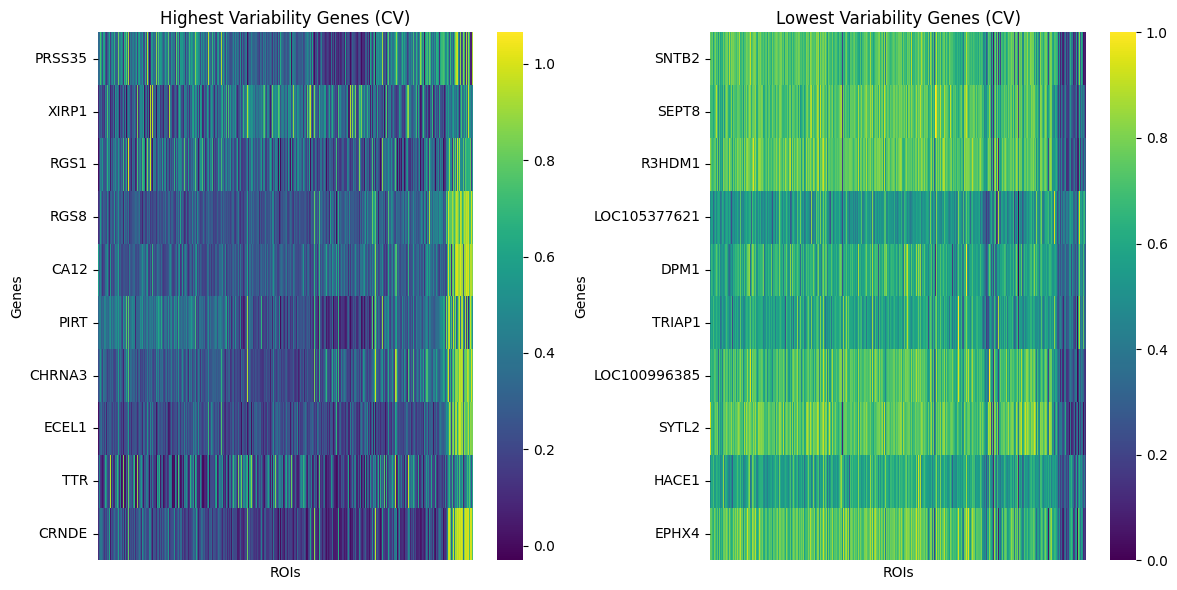

Filtered out 12506 low-variability genes.
Retained 3127 genes (above 80th percentile of cv).
Calculating ROI x ROI gene correlation matrix...
Finished calculating gene correlation matrix.
Calculating ROI x ROI gene correlation matrix...
Finished calculating gene correlation matrix.

--- Final Variable Shapes ---
Coordinates of cleaned ROIs (roiCoor_clean): (2140, 3)
Median cleaned structural connectivity (scm_clean): (2140, 2140)
Median cleaned functional connectivity (fcm_clean): (2140, 2140)
Interpolated gene expression (G_mat_int, Genes x ROIs): (3127, 2140)
ROI genetic correlation matrix (gcm, ROIs x ROIs): (2140, 2140)
Cleaned distance matrix (D_clean): (2140, 2140)
Gene names: 3127


In [ ]:
# === Data Prep ===

main_dir = 'iPA_2165' # Make sure this matches unzipped file folder name

# --- Define directories ---
fc_dir = os.path.join(main_dir, 'fc')
sc_dir = os.path.join(main_dir, 'sc')

# --- Get lists of files ---
try:
    fc_files_all = [f for f in os.listdir(fc_dir) if f.startswith('fc_sub-') and f.endswith('.csv')]
    sc_files_all = [f for f in os.listdir(sc_dir) if f.startswith('sub-') and f.endswith('_SC.csv')]
    fc_files_all.sort() # Ensure consistent order
    sc_files_all.sort()
except FileNotFoundError:
    print(f"Error: Could not find directories {fc_dir} or {sc_dir}.")
    print("Please ensure you have uploaded the data and the main_dir variable is correct.")
    # Stop execution if directories not found
    raise

# --- Extract subject IDs ---
# Use regular expressions to robustly extract IDs
fc_subjects = [re.search(r'fc_sub-(.*)\.csv', f).group(1) for f in fc_files_all]
sc_subjects = [re.search(r'sub-(.*)_SC\.csv', f).group(1) for f in sc_files_all]

# --- Find common subjects ---
common_subjects, fc_indices, sc_indices = np.intersect1d(fc_subjects, sc_subjects, return_indices=True)

# Sort indices to maintain original file order corresponding to common subjects
fc_files = [fc_files_all[i] for i in fc_indices]
sc_files = [sc_files_all[i] for i in sc_indices]

print(f"Found {len(common_subjects)} common subjects.")

# --- Load matrices ---
n_subjects = len(common_subjects)  # Get the number of subjects
N = pd.read_csv(os.path.join(fc_dir, fc_files[0]), header=None, delimiter=' ').values.shape[0] # Assuming all connectomes have the same size
fcStack = np.zeros((N, N, n_subjects))  # Pre-allocate the stack

print("Loading FC matrices...")
for i in range(len(common_subjects)):
    if (i+1) % 20 == 0: # Print progress
      print(f"  Loading subject {i+1}/{len(common_subjects)}")
    # Load FC
    fc_file_path = os.path.join(fc_dir, fc_files[i])
    fcStack[:, :, i] = pd.read_csv(fc_file_path, header=None, delimiter=' ').values
print("Finished loading matrices.")

# Compute Median Connectomes
print("Computing median connectomes...")
fcm = np.median(fcStack, axis=2)
del fcStack
print("Finished computing median F-connectomes.")

scStack = np.zeros((N, N, n_subjects))  # Pre-allocate the stack of SC matrices

print("Loading SC matrices...")
for i in range(len(common_subjects)):
    if (i+1) % 20 == 0: # Print progress
      print(f"  Loading subject {i+1}/{len(common_subjects)}")
    # Load SC
    sc_file_path = os.path.join(sc_dir, sc_files[i])
    scStack[:, :, i] = pd.read_csv(sc_file_path, header=None, delimiter=' ').values
print("Finished loading matrices.")

# Compute Median Connectomes
print("Computing median connectomes...")
scm = np.median(scStack, axis=2)
del scStack
print("Finished computing median S-connectomes.")



# --- Load Coordinates and Transcriptomics ---
print("Loading ROI coordinates and transcriptomics...")
try:
    roi_coor_df = pd.read_csv(os.path.join(main_dir, f'{main_dir}.csv'), header=0) # Assuming no header
    roiCoor = roi_coor_df.iloc[:, 1:4].values # Select columns 1, 2, 3 (0-based index)

    # Load transcriptomics with gene names as index and ROIs as columns
    G_df = pd.read_csv(os.path.join(main_dir, 'transcriptomics.csv'), index_col=0)
    G_mat = G_df.values # Genes x ROIs
    gene_names = G_df.index.tolist()
    roi_names_genes = G_df.columns.tolist() # Assuming columns are ROI identifiers
except FileNotFoundError:
    print(f"Error: Could not find coordinate or transcriptomics file in {main_dir}.")
    raise
except Exception as e:
    print(f"Error loading coordinates or transcriptomics: {e}")
    raise
print("Finished loading coordinates and transcriptomics.")


# --- Clean Connectomes ---
print("Cleaning connectomes (removing disconnected ROIs, matching density)...")
fcm_clean, scm_clean, removed_rois_fc_abs, removed_rois_sc_abs, fc_threshold = \
    equal_clean_connectomes_absolute(fcm, scm)

# Combine all removed ROIs
removed_rois_all = np.union1d(removed_rois_fc_abs, removed_rois_sc_abs).astype(int)

# Apply cleaning to stacks and coordinates
roiCoor_clean = np.delete(roiCoor, removed_rois_all, axis=0)

# skipping computing the stacks to save memory - uncomment to recover them for other analyses
#scStack_clean = np.delete(scStack, removed_rois_all, axis=0)
#scStack_clean = np.delete(scStack_clean, removed_rois_all, axis=1)
#fcStack_clean = np.delete(fcStack, removed_rois_all, axis=0)
#fcStack_clean = np.delete(fcStack_clean, removed_rois_all, axis=1)

# Apply cleaning to Gene Expression Matrix (remove corresponding columns)
# Check if columns in G_df correspond to the original ROIs
if G_mat.shape[1] == N: # Check if number of columns matches original N
    G_mat_cleaned = np.delete(G_mat, removed_rois_all, axis=1)
    # Update roi_names if they were extracted
    if 'roi_names_genes' in locals():
         roi_names_genes_clean = [roi_names_genes[i] for i in range(N) if i not in removed_rois_all]
else:
    print(f"Warning: Number of ROIs in transcriptomics ({G_mat.shape[1]}) does not match connectomes ({N}). Skipping cleaning of G_mat.")
    G_mat_cleaned = G_mat # Use original if dimensions don't match
    roi_names_genes_clean = roi_names_genes if 'roi_names_genes' in locals() else None

print("Finished cleaning.")

# --- Distance Matrix ---
print("Calculating distance matrix...")
D_clean = squareform(pdist(roiCoor_clean))
print("Finished calculating distance matrix.")

# --- Gene Interpolation using gaussian processes
print("Performing gene expression interpolation for missing ROIs...")

# Ensure G_mat is float for NaN representation
G_mat_for_interp = G_mat_cleaned.astype(float)
n_genes, n_rois_clean = G_mat_for_interp.shape

# Find indices of ROIs (columns) that contain ANY NaN values in the *cleaned* matrix
# Assuming if one gene is NaN for an ROI, all genes are NaN for that ROI.
nan_mask_per_roi = np.isnan(G_mat_for_interp).any(axis=0) # Check if ANY gene is NaN for each ROI
idx_miss_clean = np.where(nan_mask_per_roi)[0]
idx_obs_clean = np.where(~nan_mask_per_roi)[0]

# Initialize G_mat_int
G_mat_int = G_mat_for_interp.copy()

if idx_miss_clean.size > 0 and idx_obs_clean.size > 0:
    print(f"Found {len(idx_miss_clean)} ROIs with missing gene expression data out of {n_rois_clean}.")
    print("Interpolating using GP based on ROI distances...")

    #    Calculate the GP interpolation matrix M
    #    Uses distances between ROIs (D_clean)
    #    Needs indices relative to the *cleaned* set of ROIs
    try:
        # L=20, sigma=1, sigma0=1 for GP params
        M = gp_interpolation_matrix(D_clean, idx_miss_clean, L=20, sigma=1, sigma0=1)
        # M shape: (num_missing_ROIs_clean) x (num_observed_ROIs_clean)
        print(f"  Computed interpolation matrix M with shape: {M.shape}")

        # Get the expression data for observed ROIs
        #    G_obs shape: (n_genes) x (num_observed_ROIs_clean)
        G_obs = G_mat_int[:, idx_obs_clean]

        # Interpolate the expression data for missing ROIs
        #    G_interp = G_obs @ M.T
        #    Shapes: (Genes x n_obs) @ (n_obs x n_miss) -> (Genes x n_miss)
        G_interp = G_obs @ M.T
        print(f"  Computed interpolated gene data G_interp with shape: {G_interp.shape}")


        # Assign the interpolated values back to the main matrix
        G_mat_int[:, idx_miss_clean] = G_interp
        print("  Assigned interpolated values.")

    except np.linalg.LinAlgError:
        print("  Error: Matrix inversion failed during GP interpolation (K_obs_obs might be singular).")
        print("  Skipping interpolation. G_mat_int will retain NaNs.")
        # This can happen when the GP interpolation matrix is singular,
        # can increase sigma0 value to regularize

    except Exception as e:
        print(f"  An unexpected error occurred during GP interpolation: {e}")
        print("  Skipping interpolation. G_mat_int will retain NaNs.")

elif idx_miss_clean.size == n_rois_clean:
    print("Error: All ROIs seem to have missing data. Cannot perform interpolation.")
    # G_mat_int will be all NaN or original data if no NaNs detected initially
elif idx_miss_clean.size == 0:
    print("No ROIs found with missing data. Skipping interpolation.")
    # G_mat_int is already complete

# Final check for NaNs after attempting interpolation
if np.any(np.isnan(G_mat_int)):
    remaining_nans = np.sum(np.isnan(G_mat_int))
    print(f"Warning: {remaining_nans} NaN values still present after interpolation attempt.")


    # Optional: Implement a fallback NaN filling strategy if needed currently off
    # print("Filling remaining NaNs with gene-wise mean...")
    # col_means = np.nanmean(G_mat_int, axis=0) # Use column means (ROI means) if appropriate? Or gene means?
    # nan_indices = np.isnan(G_mat_int)
    # G_mat_int[nan_indices] = np.take(col_means, np.where(nan_indices)[1]) # Fill based on ROI mean across genes
    # Check again: print(f"NaNs after fill: {np.sum(np.isnan(G_mat_int))}")

print("Finished interpolation step.")

# --- Gene Variability Filtering ---
print("Filtering genes by variability...")
variability_metric = 'cv' # Options: 'variance', 'std', 'cv'
variability_quantile_threshold = 80 # Remove genes below this percentile (e.g., 20 removes bottom 20%)

n_genes_before = G_mat_int.shape[0]

if variability_metric == 'variance':
    gene_variability = np.var(G_mat_int, axis=1)
elif variability_metric == 'std':
    gene_variability = np.std(G_mat_int, axis=1)
elif variability_metric == 'cv':
     # Coefficient of variation - handle potential division by zero or near-zero means
     gene_means = np.mean(G_mat_int, axis=1)
     gene_stds = np.std(G_mat_int, axis=1)
     # Avoid division by zero, set CV to 0 if mean is very small
     gene_variability = np.divide(gene_stds, gene_means, out=np.zeros_like(gene_stds), where=np.abs(gene_means)>1e-6)
else:
    raise ValueError("Invalid variability_metric specified.")

# Check for NaNs in variability (can happen with CV if mean is zero)
if np.any(np.isnan(gene_variability)):
    print("Warning: NaN found in variability metric. Setting those to zero variability.")
    gene_variability[np.isnan(gene_variability)] = 0

# --- Visualize Highest and Lowest Variability Genes ---
# Number of genes to visualize
num_genes_to_visualize = 10

# Get indices of genes with highest and lowest variability
sorted_indices = np.argsort(gene_variability)
highest_var_indices = sorted_indices[-num_genes_to_visualize:]
lowest_var_indices = sorted_indices[:num_genes_to_visualize]

# Get the corresponding gene names
highest_var_genes = [gene_names[i] for i in highest_var_indices]
lowest_var_genes = [gene_names[i] for i in lowest_var_indices]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Highest variability genes
sns.heatmap(G_mat_int[highest_var_indices, :], cmap='viridis',
            xticklabels=False, yticklabels=highest_var_genes, ax=axes[0])
axes[0].set_title(f'Highest Variability Genes ({variability_metric.upper()})')
axes[0].set_ylabel('Genes')
axes[0].set_xlabel('ROIs')

# Lowest variability genes
sns.heatmap(G_mat_int[lowest_var_indices, :], cmap='viridis',
            xticklabels=False, yticklabels=lowest_var_genes, ax=axes[1])
axes[1].set_title(f'Lowest Variability Genes ({variability_metric.upper()})')
axes[1].set_ylabel('Genes')
axes[1].set_xlabel('ROIs')

plt.tight_layout()
plt.show()
# --- End Visualization ---

# Determine the threshold value
threshold_value = np.percentile(gene_variability, variability_quantile_threshold)

# Create mask for genes to KEEP (variability > threshold)
keep_gene_mask = gene_variability > threshold_value

# Apply filter
G_mat_int = G_mat_int[keep_gene_mask, :]
gene_names = [gene_names[i] for i, keep in enumerate(keep_gene_mask) if keep]

n_genes_after = G_mat_int.shape[0]
print(f"Filtered out {n_genes_before - n_genes_after} low-variability genes.")
print(f"Retained {n_genes_after} genes (above {variability_quantile_threshold}th percentile of {variability_metric}).")


# --- Gene Correlation Matrix (ROI x ROI) ---
# (Rest of the code remains the same)
print("Calculating ROI x ROI gene correlation matrix...")
# Correlate columns (ROIs) based on their gene expression profiles (rows)
# Need to transpose G_mat_int (Genes x ROIs -> ROIs x Genes) before correlating
if np.any(np.isnan(G_mat_int)):
    print("Warning: Cannot compute correlation matrix due to remaining NaNs. Skipping gcm calculation.")
    gcm = np.full((n_rois_clean, n_rois_clean), np.nan) # Create a NaN matrix
else:
    gcm = np.corrcoef(G_mat_int.T) # Result is ROI x ROI
    print("Finished calculating gene correlation matrix.")


# --- Gene Correlation Matrix (ROI x ROI) ---
print("Calculating ROI x ROI gene correlation matrix...")
# Correlate columns (ROIs) based on their gene expression profiles (rows)
# Need to transpose G_mat_int (Genes x ROIs -> ROIs x Genes) before correlating
gcm = np.corrcoef(G_mat_int.T) # Result is ROI x ROI
print("Finished calculating gene correlation matrix.")

# --- Display Final Shapes ---
print("\n--- Final Variable Shapes ---")
print(f"Coordinates of cleaned ROIs (roiCoor_clean): {roiCoor_clean.shape}")
print(f"Median cleaned structural connectivity (scm_clean): {scm_clean.shape}")
print(f"Median cleaned functional connectivity (fcm_clean): {fcm_clean.shape}")
#print(f"Cleaned structural connectivity stack (scStack_clean): {scStack_clean.shape}")
#print(f"Cleaned functional connectivity stack (fcStack_clean): {fcStack_clean.shape}")
print(f"Interpolated gene expression (G_mat_int, Genes x ROIs): {G_mat_int.shape}")
print(f"ROI genetic correlation matrix (gcm, ROIs x ROIs): {gcm.shape}")
print(f"Cleaned distance matrix (D_clean): {D_clean.shape}")
print(f"Gene names: {len(gene_names)}")
# print(f"Cleaned ROI names (from genes): {len(roi_names_genes_clean)}" if 'roi_names_genes_clean' in locals() else "")


## clean up big big variables that wont be used in the next analyses -
# keep if you have lots of mem
del G_df
del G_mat_for_interp
del G_interp
del roi_coor_df
del gene_means
del gene_stds
del gene_variability
del idx_miss_clean
del idx_obs_clean
del M
del nan_mask_per_roi
del removed_rois_all
del removed_rois_fc_abs
del removed_rois_sc_abs

In [ ]:
# show variable memory sizes
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))




                     G_mat_int: 51.1 MiB
                           fcm: 35.8 MiB
                           scm: 35.8 MiB
                       D_clean: 34.9 MiB
                           gcm: 34.9 MiB
                sorted_indices: 122.2 KiB
                 roiCoor_clean: 50.3 KiB
                    gene_names: 25.4 KiB
               roi_names_genes: 16.8 KiB
         roi_names_genes_clean: 16.8 KiB


Visualizing Median Connectomes and Distance Matrix...


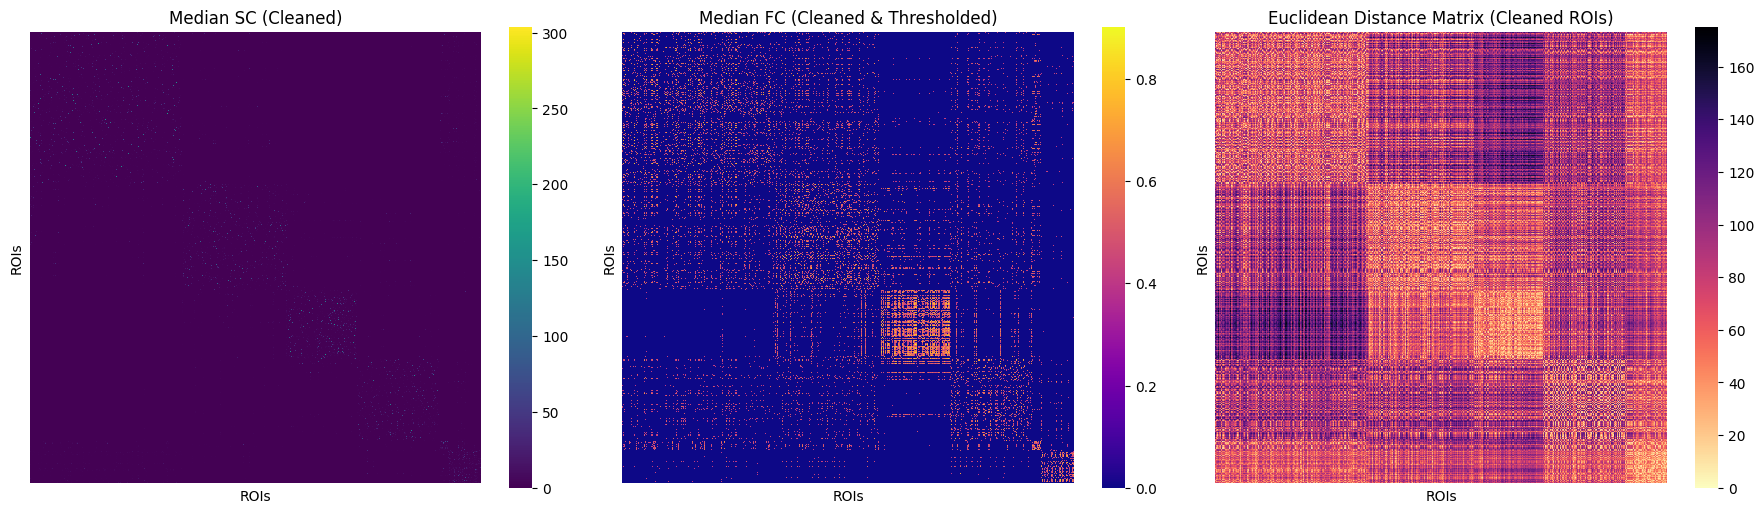


Basic Stats:
SCM Cleaned: Min=0.00, Max=303.43, Mean=0.2962, Density=0.0716
FCM Cleaned: Min=0.00, Max=0.90, Mean=0.0363, Density=0.0729
Distance Cleaned: Min=0.00, Max=174.88, Mean=81.67


In [ ]:
print("Visualizing Median Connectomes and Distance Matrix...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Median Structural Connectome (SCM)
sns.heatmap(scm_clean, cmap='viridis', square=True, cbar=True, ax=axes[0], xticklabels=False, yticklabels=False)
axes[0].set_title('Median SC (Cleaned)')
axes[0].set_xlabel('ROIs')
axes[0].set_ylabel('ROIs')

# 2. Median Functional Connectome (FCM)
sns.heatmap(fcm_clean, cmap='plasma', square=True, cbar=True, ax=axes[1], xticklabels=False, yticklabels=False)
axes[1].set_title('Median FC (Cleaned & Thresholded)')
axes[1].set_xlabel('ROIs')
axes[1].set_ylabel('ROIs')


# 3. Distance Matrix
sns.heatmap(D_clean, cmap='magma_r', square=True, cbar=True, ax=axes[2], xticklabels=False, yticklabels=False) # _r reverses magma
axes[2].set_title('Euclidean Distance Matrix (Cleaned ROIs)')
axes[2].set_xlabel('ROIs')
axes[2].set_ylabel('ROIs')


plt.tight_layout()
plt.show()

# --- Basic Stats ---
print("\nBasic Stats:")
print(f"SCM Cleaned: Min={np.min(scm_clean):.2f}, Max={np.max(scm_clean):.2f}, Mean={np.mean(scm_clean):.4f}, Density={np.sum(scm_clean > 1e-9)/scm_clean.size:.4f}")
print(f"FCM Cleaned: Min={np.min(fcm_clean):.2f}, Max={np.max(fcm_clean):.2f}, Mean={np.mean(fcm_clean):.4f}, Density={np.sum(np.abs(fcm_clean) > 1e-9)/fcm_clean.size:.4f}") # Use abs for FC density
print(f"Distance Cleaned: Min={np.min(D_clean):.2f}, Max={np.max(D_clean):.2f}, Mean={np.mean(D_clean):.2f}")

Visualizing Gene Expression Matrix (Sample) and Checking NaNs...
PASSED: No NaN values found in G_mat_int.


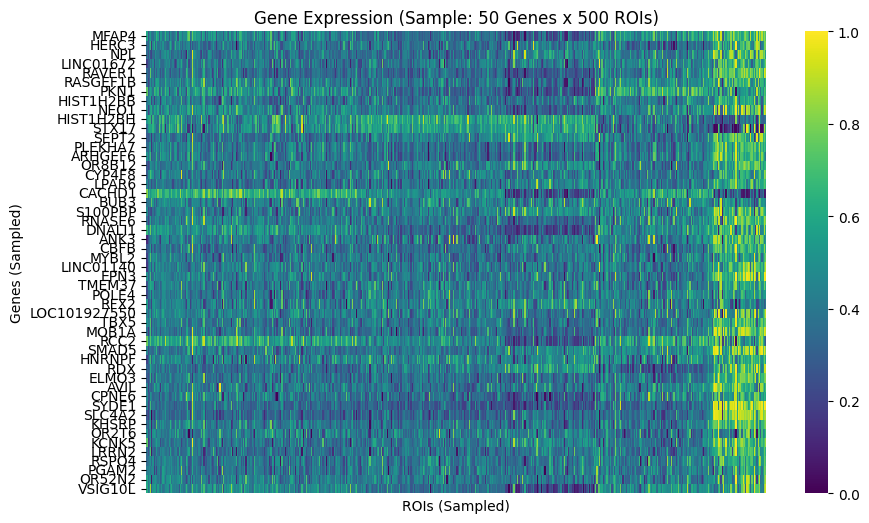

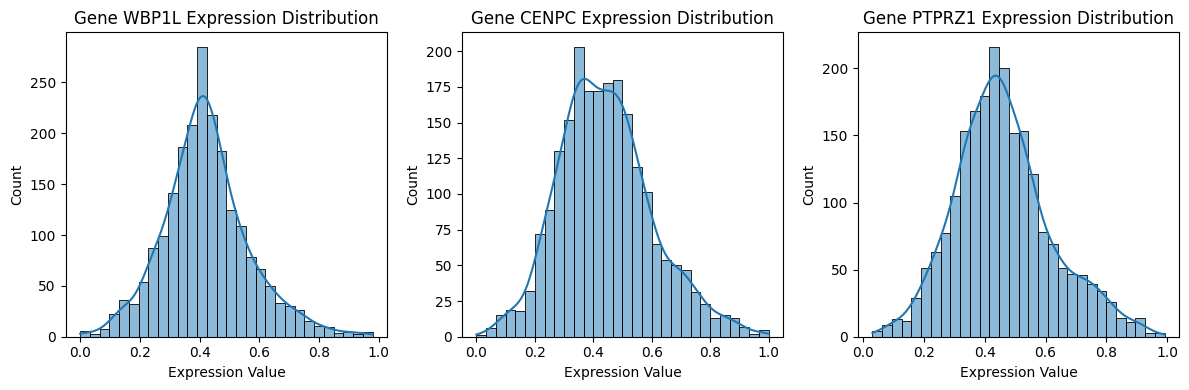

In [ ]:
# show some gene exp data
import matplotlib.pyplot as plt
import seaborn as sns

print("Visualizing Gene Expression Matrix (Sample) and Checking NaNs...")

# Check for NaNs
nan_count = np.sum(np.isnan(G_mat_int))
if nan_count > 0:
    print(f"WARNING: Found {nan_count} NaN values remaining in G_mat_int!")
else:
    print("PASSED: No NaN values found in G_mat_int.")

# Visualize a small sample to get a feel for the data
n_genes_to_show = 50
n_rois_to_show = 500

plt.figure(figsize=(10, 6))
# 1. Sample gene *names* instead of indices:
gene_names_sample = np.random.choice(gene_names, n_genes_to_show, replace=False)
roi_indices_sample = np.random.choice(G_mat_int.shape[1], n_rois_to_show, replace=False)

# 2. Get the corresponding indices for the sampled gene names:
gene_indices_sample = [gene_names.index(name) for name in gene_names_sample]

# Sort indices for potentially cleaner visualization
gene_indices_sample.sort()
roi_indices_sample.sort()

# Extract and plot subsample
G_sample = G_mat_int[np.ix_(gene_indices_sample, roi_indices_sample)]

# 3. Use gene_names_sample for yticklabels:
sns.heatmap(G_sample, cmap='viridis', cbar=True, xticklabels=False, yticklabels=gene_names_sample)
plt.title(f'Gene Expression (Sample: {n_genes_to_show} Genes x {n_rois_to_show} ROIs)')
plt.xlabel('ROIs (Sampled)')
plt.ylabel('Genes (Sampled)')
plt.show()

# Visualize distribution of expression for a few random genes
plt.figure(figsize=(12, 4))
n_genes_hist = 3
for i in range(n_genes_hist):
    gene_idx_hist = np.random.choice(G_mat_int.shape[0])
    plt.subplot(1, n_genes_hist, i + 1)
    sns.histplot(G_mat_int[gene_idx_hist, :], kde=True, bins=30)
    plt.title(f'Gene {gene_names[gene_idx_hist]} Expression Distribution') # Use gene name in title
    plt.xlabel('Expression Value')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

Visualizing ROI x ROI Gene Correlation Matrix (GCM)...


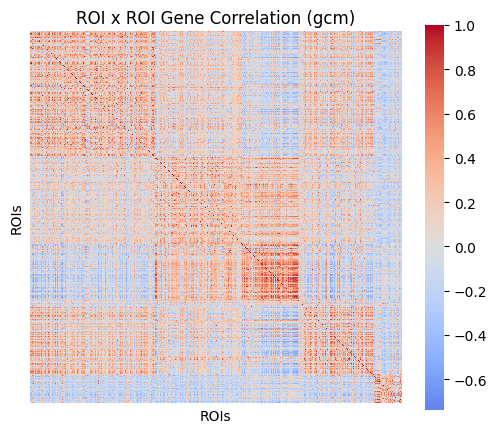

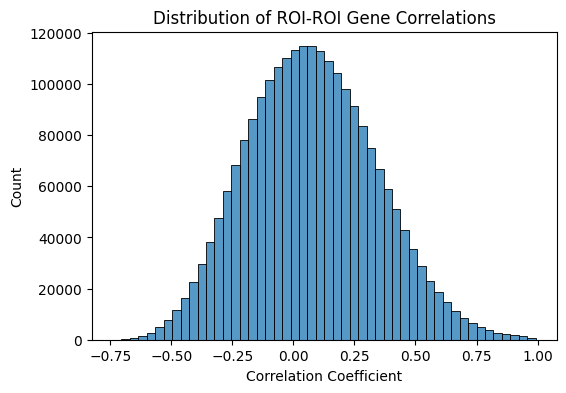

In [ ]:
# shoe gene exp corr mat
import matplotlib.pyplot as plt
import seaborn as sns

print("Visualizing ROI x ROI Gene Correlation Matrix (GCM)...")

if np.any(np.isnan(gcm)):
    print("Warning: GCM contains NaNs, cannot visualize properly.")
else:
    plt.figure(figsize=(6, 5))
    sns.heatmap(gcm, cmap='coolwarm', center=0, square=True, cbar=True, xticklabels=False, yticklabels=False)
    plt.title('ROI x ROI Gene Correlation (gcm)')
    plt.xlabel('ROIs')
    plt.ylabel('ROIs')
    plt.show()

    # Histogram of correlation values
    plt.figure(figsize=(6, 4))
    sns.histplot(gcm[np.triu_indices_from(gcm, k=1)], kde=False, bins=50) # Use upper triangle excluding diagonal
    plt.title('Distribution of ROI-ROI Gene Correlations')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Count')
    plt.show()

Starting PLS analysis...
Finished PLS analysis.
Generating plots...


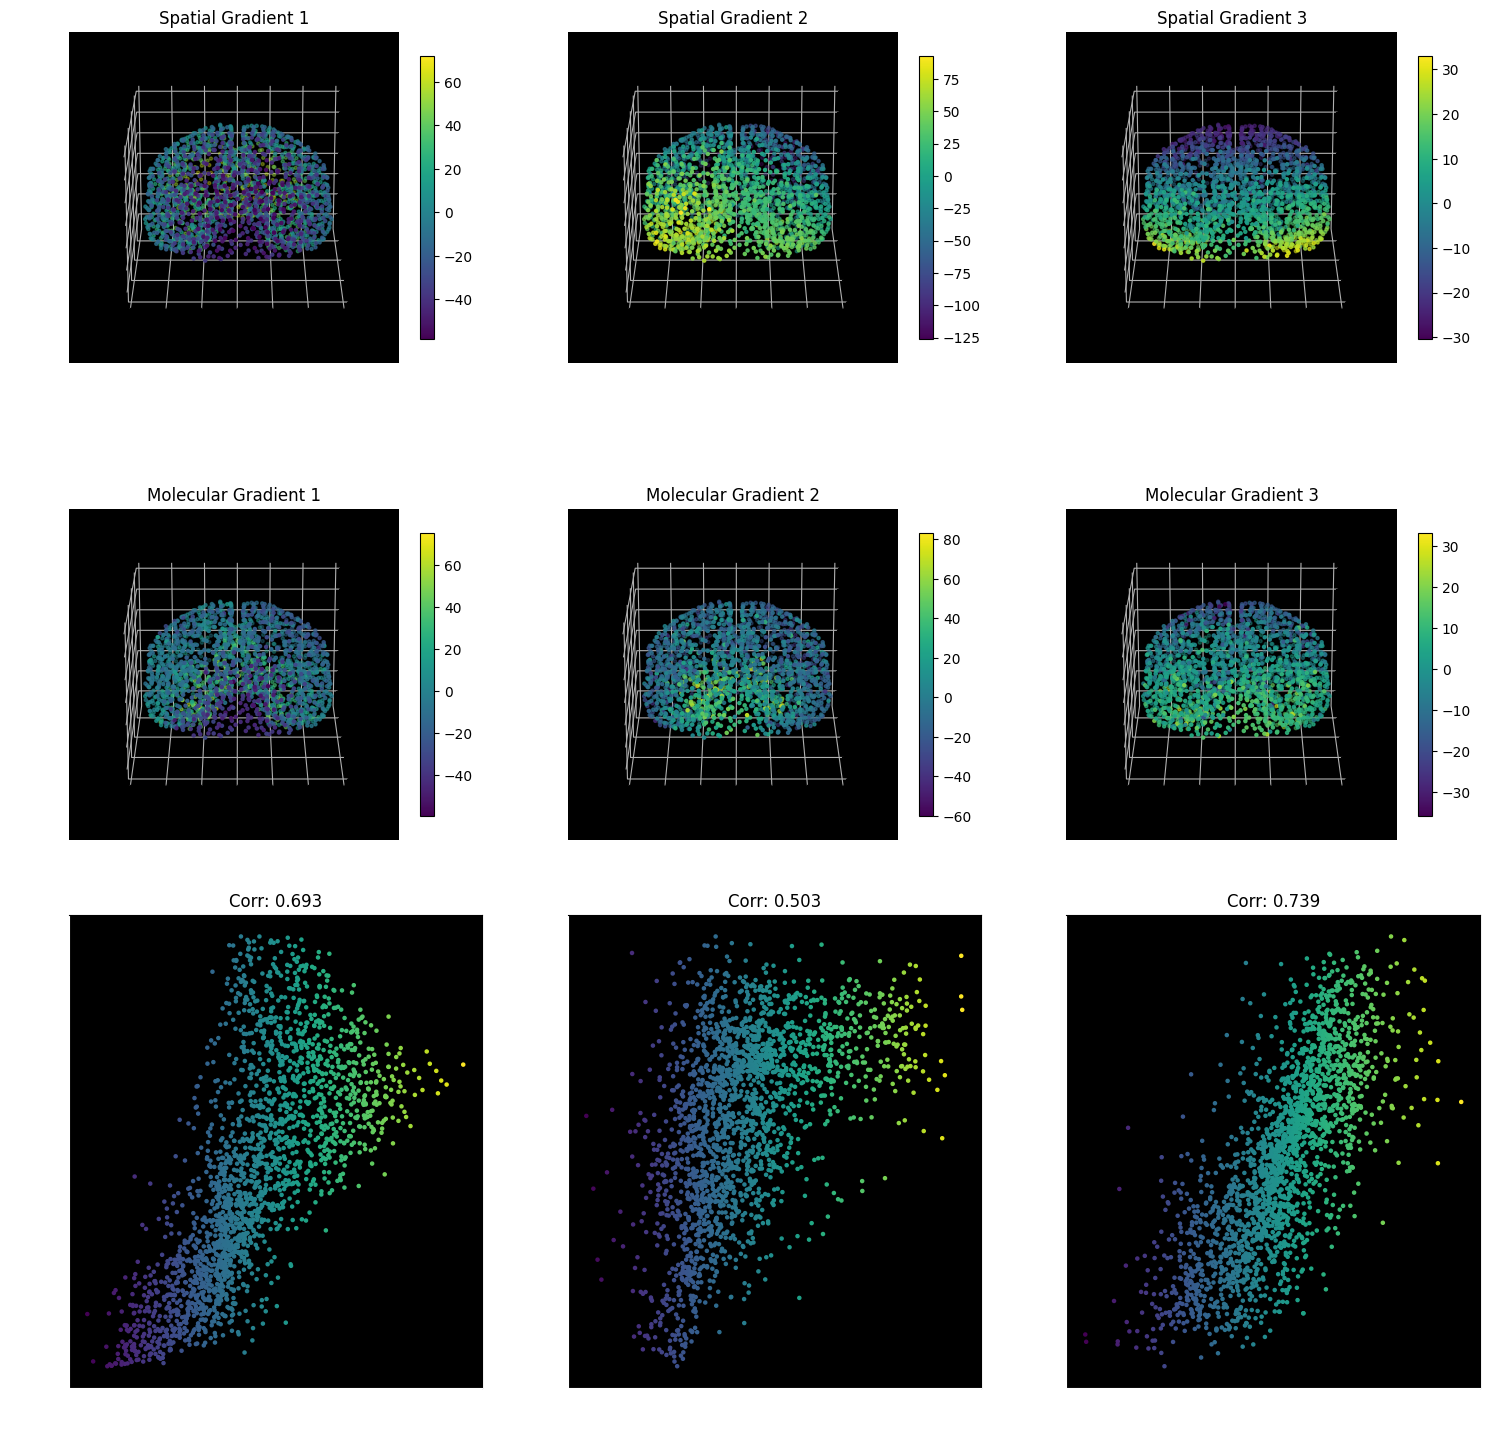

Finished generating plots.


In [ ]:
# === Analysis (Replicating Vogel et al. Fig 1) ===
print("Starting PLS analysis...")

K = 3 # Number of PLS components

# --- Prepare data for PLS ---
# X: Gene expression features (ROIs x Features)
# Y: Spatial coordinates (ROIs x 3)

# Perform PCA on gene expression data (ROIs x Genes -> ROI Scores x PCs)
# Scale data before PCA
scaler_g = StandardScaler()
G_scaled = scaler_g.fit_transform(G_mat_int.T) # Transpose to ROIs x Genes

n_pca_components = 100
pca = PCA(n_components=n_pca_components, svd_solver='full') # Use 'full' for reproducibility if needed
X_pca_scores = pca.fit_transform(G_scaled) # Shape: (n_rois_clean, n_pca_components)

# Define X and Y for PLS
X_pls = X_pca_scores
Y_pls = roiCoor_clean

# Check for NaNs before PLS
if np.any(np.isnan(X_pls)) or np.any(np.isnan(Y_pls)):
    raise ValueError("NaNs found in data prepared for PLS. Check interpolation and cleaning steps.")

# --- Perform PLS Regression ---
pls = PLSRegression(n_components=K, scale=False) # Data is already scaled if needed
# PLS expects (n_samples, n_features), here (n_rois, n_pca_comps) for X
# and (n_samples, n_targets), here (n_rois, 3) for Y
pls.fit(X_pls, Y_pls)

# --- Extract Scores ---
# XS: Scores of X data projected onto PLS components ('Molecular gradient')
# YS: Scores of Y data projected onto PLS components ('Spatial gradient')
XS = pls.x_scores_
YS = pls.y_scores_

print("Finished PLS analysis.")

# --- Visualization ---
print("Generating plots...")
dotSize = 20 # Size of dots in scatter plots

fig = plt.figure(figsize=(5 * K, 15)) # Adjust figsize as needed

for k in range(K):
    component_idx = k # 0-based index

    # Spatial Gradient plot
    ax1 = fig.add_subplot(3, K, component_idx + 1, projection='3d')
    sc1 = ax1.scatter(roiCoor_clean[:, 0], roiCoor_clean[:, 1], roiCoor_clean[:, 2],
                      s=dotSize, c=YS[:, component_idx], cmap='viridis', marker='.')
    ax1.set_title(f'Spatial Gradient {component_idx + 1}')
    ax1.set_facecolor('k') # Black background
    ax1.xaxis.set_pane_color((0,0,0,1))
    ax1.yaxis.set_pane_color((0,0,0,1))
    ax1.zaxis.set_pane_color((0,0,0,1))
    fig.colorbar(sc1, ax=ax1, shrink=0.6)
    ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')


    # Molecular Gradient plot
    ax2 = fig.add_subplot(3, K, K + component_idx + 1, projection='3d')
    sc2 = ax2.scatter(roiCoor_clean[:, 0], roiCoor_clean[:, 1], roiCoor_clean[:, 2],
                      s=dotSize, c=XS[:, component_idx], cmap='viridis', marker='.')
    ax2.set_title(f'Molecular Gradient {component_idx + 1}')
    ax2.set_facecolor('k')
    ax2.xaxis.set_pane_color((0,0,0,1))
    ax2.yaxis.set_pane_color((0,0,0,1))
    ax2.zaxis.set_pane_color((0,0,0,1))
    fig.colorbar(sc2, ax=ax2, shrink=0.6)
    ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_zlabel('Z')

    # Correlation plot
    ax3 = fig.add_subplot(3, K, 2 * K + component_idx + 1)
    correlation = np.corrcoef(XS[:, component_idx], YS[:, component_idx])[0, 1]
    sc3 = ax3.scatter(XS[:, component_idx], YS[:, component_idx],
                      s=dotSize, c=XS[:, component_idx], cmap='viridis', marker='.')
    ax3.set_title(f'Corr: {correlation:.3f}')
    ax3.set_facecolor('k')
    ax3.spines['bottom'].set_color('white'); ax3.spines['left'].set_color('white') # Make axes visible
    ax3.xaxis.label.set_color('white'); ax3.yaxis.label.set_color('white')
    ax3.tick_params(axis='x', colors='white'); ax3.tick_params(axis='y', colors='white')
    ax3.set_xlabel('Molecular Score')
    ax3.set_ylabel('Spatial Score')

    # change camera angle for brains
    ax1.view_init(elev=20, azim=-90)
    ax2.view_init(elev=20, azim=-90)




plt.tight_layout()
plt.show()

print("Finished generating plots.")

In [ ]:
!pip install statsmodels netneurotools gseapy matplotlib_venn # gseapy for GO terms
import netneurotools.stats as nnstats #this one has the spin test
import gseapy as gp
from statsmodels.sandbox.stats.multicomp import multipletests # For FDR
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, zscore
from scipy.spatial.distance import squareform

print("Required libraries for H1/H2 loaded/installed.")

Required libraries for H1/H2 loaded/installed.


Testing Hypothesis: CGE vs. Distance, does it decay above/below expectation by chance?
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-14-7dd037a00377>:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_cge_observed = binned_cge.groupby('bin')['cge'].mean()


Generating 10000 spatial permutations (spin test)...
Loaded spins from Google Drive.
Calculating null CGE vs. Distance curves...


<ipython-input-14-7dd037a00377>:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_cge_null[i, :] = binned_cge_perm.groupby('bin')['cge_perm'].mean().values


 Permutation 100/10000
 Permutation 200/10000
 Permutation 300/10000
 Permutation 400/10000
 Permutation 500/10000
 Permutation 600/10000
 Permutation 700/10000
 Permutation 800/10000
 Permutation 900/10000
 Permutation 1000/10000
 Permutation 1100/10000
 Permutation 1200/10000
 Permutation 1300/10000
 Permutation 1400/10000
 Permutation 1500/10000
 Permutation 1600/10000
 Permutation 1700/10000
 Permutation 1800/10000
 Permutation 1900/10000
 Permutation 2000/10000
 Permutation 2100/10000
 Permutation 2200/10000
 Permutation 2300/10000
 Permutation 2400/10000
 Permutation 2500/10000
 Permutation 2600/10000
 Permutation 2700/10000
 Permutation 2800/10000
 Permutation 2900/10000
 Permutation 3000/10000
 Permutation 3100/10000
 Permutation 3200/10000
 Permutation 3300/10000
 Permutation 3400/10000
 Permutation 3500/10000
 Permutation 3600/10000
 Permutation 3700/10000
 Permutation 3800/10000
 Permutation 3900/10000
 Permutation 4000/10000
 Permutation 4100/10000
 Permutation 4200/10000
 

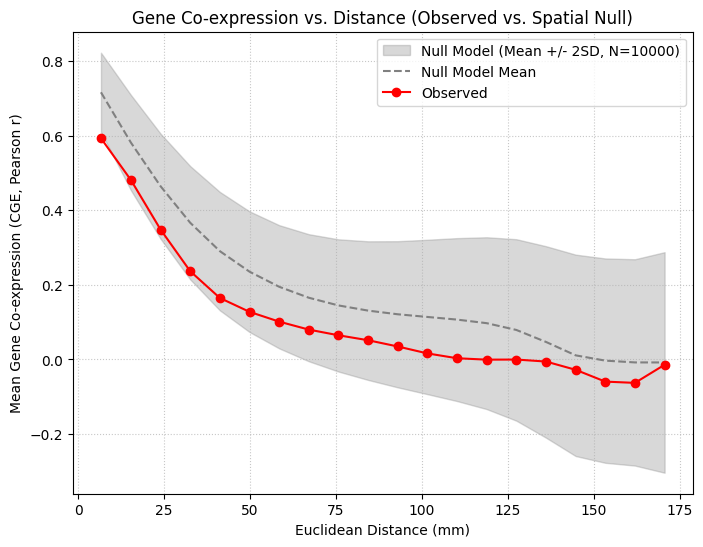

--- Finished Hypothesis 1 ---


In [ ]:
print("Testing Hypothesis: CGE vs. Distance, does it decay above/below expectation by chance?")
import pickle
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Specify the file path in your Google Drive
file_path = '/content/drive/MyDrive/spins2165.pkl'  # Replace with your desired path

# 1. Data Preparation
# gcm (ROI x ROI gene correlation matrix) and D_clean (ROI x ROI distance matrix) are already computed.
n_rois_clean = D_clean.shape[0]

# We need the upper triangle of the matrices, excluding the diagonal
indices_upper = np.triu_indices(n_rois_clean, k=1)
distances_flat = D_clean[indices_upper]
cge_flat = gcm[indices_upper] # Correlation between ROI gene profiles

# Remove NaNs that might arise if gcm calculation had issues
valid_indices = ~np.isnan(cge_flat)
distances_flat = distances_flat[valid_indices]
cge_flat = cge_flat[valid_indices]

# 2. Binning and Averaging (Observed Data)
n_bins = 20 # Number of distance bins
try:
    # Use pandas cut for robust binning
    distance_bins = pd.cut(distances_flat, bins=n_bins)
    # Calculate mean CGE per bin
    binned_cge = pd.DataFrame({'cge': cge_flat, 'bin': distance_bins})
    mean_cge_observed = binned_cge.groupby('bin')['cge'].mean()
    bin_centers = [(interval.left + interval.right) / 2 for interval in mean_cge_observed.index]
except ValueError as e:
    print(f"Error during binning: {e}. Check distance values.")
    mean_cge_observed = None # Skip plotting if binning fails

# 3. Spatial Null Model (Spin Test)
n_permutations = 10000 # Use 1000 for speed, increase to 10000 for better significance
print(f"Generating {n_permutations} spatial permutations (spin test)...")

try:
    # Try to load spins from the file
    with open(file_path, 'rb') as f:
        spins = pickle.load(f)
    print("Loaded spins from Google Drive.")

except FileNotFoundError:
    # If the file doesn't exist, generate spins and save them
    print("File not found. Generating spins and saving to Google Drive.")

    # Generate spins based on the cleaned coordinates
    # `netneurotools` needs coordinates in shape (n_nodes, 3)
    # Create hemiid based on roiCoor[:, 0]
    hemiid_clean = np.where(roiCoor_clean[:, 0] < 0, 0, 1)  # 0 for left, 1 for right
    spins, cost, *_ = nnstats.gen_spinsamples(roiCoor_clean, hemiid=hemiid_clean,
                                       n_rotate=n_permutations, seed=1234,return_cost=True)
    # spins shape: (n_rois_clean, n_permutations)
    with open(file_path, 'wb') as f:
        pickle.dump(spins, f)
    print("Saved spins to Google Drive.")



print("Calculating null CGE vs. Distance curves...")
# Store null results
mean_cge_null = np.zeros((n_permutations, n_bins))

# Use the original G_mat_int (Genes x ROIs)
if np.any(np.isnan(G_mat_int)):
     print("Warning: NaNs in G_mat_int. Skipping null model calculation.")
     mean_cge_null = None
else:
    G_mat_perm = G_mat_int.T # Now ROIs x Genes for easier permutation
    for i in range(n_permutations):
        if (i+1)%100 == 0: print(f" Permutation {i+1}/{n_permutations}")
        # Permute the ROI dimension of the gene expression matrix
        permuted_indices = spins[:, i]
        G_perm_i = G_mat_perm[permuted_indices, :]

        # Recalculate the ROI-ROI correlation matrix for the permuted data
        gcm_perm_i = np.corrcoef(G_perm_i) # ROI x ROI
        cge_flat_perm_i = gcm_perm_i[indices_upper]

        # Bin and average the permuted CGE values
        # Note: Using the original distance bins
        binned_cge_perm = pd.DataFrame({'cge_perm': cge_flat_perm_i, 'bin': distance_bins})
        mean_cge_null[i, :] = binned_cge_perm.groupby('bin')['cge_perm'].mean().values

# 4. Plotting
if mean_cge_observed is not None and mean_cge_null is not None:
    print("Plotting CGE vs. Distance...")
    plt.figure(figsize=(8, 6))

    # Plot null distribution (mean +/- 2*std or percentiles)
    null_mean = np.mean(mean_cge_null, axis=0)
    null_std = np.std(mean_cge_null, axis=0)
    # null_5th = np.percentile(mean_cge_null, 5, axis=0)
    # null_95th = np.percentile(mean_cge_null, 95, axis=0)

    plt.fill_between(bin_centers, null_mean - 2 * null_std, null_mean + 2 * null_std,
                     color='gray', alpha=0.3, label=f'Null Model (Mean +/- 2SD, N={n_permutations})')
    plt.plot(bin_centers, null_mean, color='gray', linestyle='--', label='Null Model Mean')

    # Plot observed data
    plt.plot(bin_centers, mean_cge_observed.values, marker='o', linestyle='-', color='red', label='Observed')

    plt.xlabel('Euclidean Distance (mm)')
    plt.ylabel('Mean Gene Co-expression (CGE, Pearson r)')
    plt.title('Gene Co-expression vs. Distance (Observed vs. Spatial Null)')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.show()
else:
    print("Skipping CGE vs Distance plot due to previous errors.")

print("--- Finished Hypothesis 1 ---")

--- H1 Additional Visualizations ---


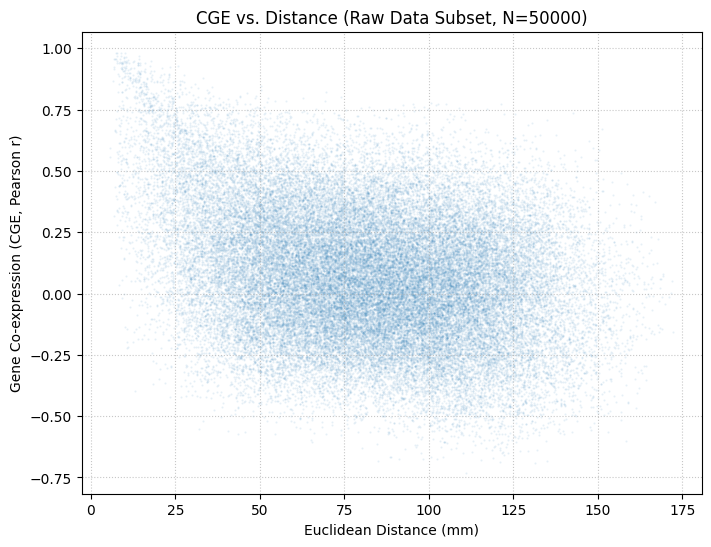

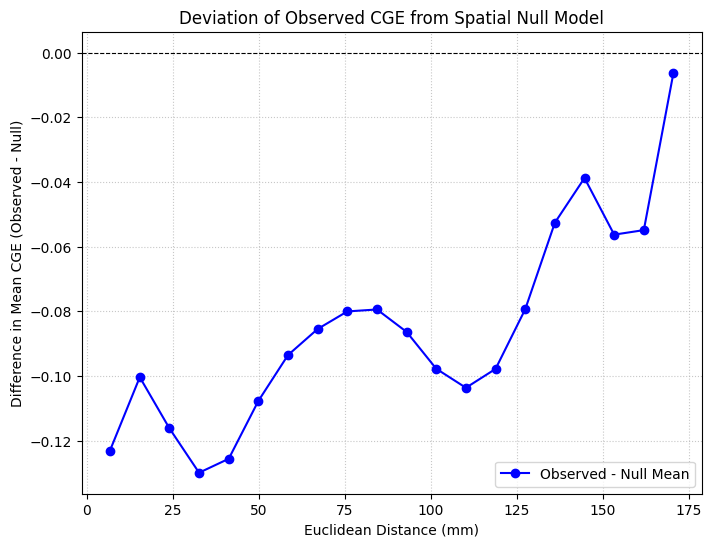

--- Finished H1 Additional Visualizations ---


In [ ]:
print("--- H1 Additional Visualizations ---")

# 1. Scatter plot of CGE vs Distance (Raw/Subset)
plt.figure(figsize=(8, 6))
n_points_to_plot = 50000 # Plot a random subset to avoid overplotting
if len(cge_flat) > n_points_to_plot:
    subset_indices = np.random.choice(len(cge_flat), n_points_to_plot, replace=False)
else:
    subset_indices = np.arange(len(cge_flat))

plt.scatter(distances_flat[subset_indices], cge_flat[subset_indices],
            s=1, alpha=0.1, marker='.')
plt.xlabel('Euclidean Distance (mm)')
plt.ylabel('Gene Co-expression (CGE, Pearson r)')
plt.title(f'CGE vs. Distance (Raw Data Subset, N={len(subset_indices)})')
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

# 2. Difference between Observed and Null Mean CGE
if mean_cge_observed is not None and mean_cge_null is not None:
    plt.figure(figsize=(8, 6))
    difference = mean_cge_observed.values - null_mean
    # Optional: Error bars based on null standard deviation
    # plt.errorbar(bin_centers, difference, yerr=null_std, fmt='o-', color='blue', label='Observed - Null Mean')
    plt.plot(bin_centers, difference, marker='o', linestyle='-', color='blue', label='Observed - Null Mean')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.xlabel('Euclidean Distance (mm)')
    plt.ylabel('Difference in Mean CGE (Observed - Null)')
    plt.title('Deviation of Observed CGE from Spatial Null Model')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.show()
else:
    print("Skipping difference plot due to missing data.")

print("--- Finished H1 Additional Visualizations ---")

In [ ]:
# some ways to speed up perm tests - they are v slow
import numpy as np
from scipy.stats import pearsonr, spearmanr # Import spearmanr if using
from netneurotools.stats import _chk2_asarray # Private helper for input checking
from netneurotools.stats import check_random_state # For seed handling

def efficient_pearsonr(a, b, axis=0):
    """
    Calculates pearson correlation coefficient and p-value

    Uses numpy builtins so is slightly faster than scipy.stats.pearsonr

    Parameters
    ----------
    a, b : (N,) array_like
        Input arrays
    axis : int, optional
        Axis along which to compute correlation. Default: 0

    Returns
    -------
    corr : float
        Pearson correlation coefficient
    pval : float
        Two-tailed p-value
    """

    # NOTE: Borrowed directly from netneurotools.stats - include for completeness
    # if used outside a context where netneurotools is fully imported.
    from scipy.stats import t as sp_t

    a, b, axis = _chk2_asarray(a, b, axis)

    ma = np.mean(a, axis=axis, keepdims=True)
    mb = np.mean(b, axis=axis, keepdims=True)

    am, bm = a - ma, b - mb

    r_num = np.sum(am * bm, axis=axis)
    r_den = np.sqrt(np.sum(am * am, axis=axis) * np.sum(bm * bm, axis=axis))
    # prevent division by zero
    if np.any(r_den == 0):
        warnings.warn('Invalid value encountered in pearson correlation')
        corr = np.divide(r_num, r_den,
                         out=np.zeros_like(r_num), where=(r_den != 0))
    else:
        corr = r_num / r_den
    # BUG: RuntimeWarning: invalid value encountered in scalar divide
    # corr = np.clip(corr, -1.0, 1.0)

    df = a.shape[axis] - 2
    # handle cases with limited variance
    t_squared = corr**2 * (df / ((1.0 - corr) * (1.0 + corr)))
    pval = sp_t.sf(np.sqrt(t_squared), df) * 2

    return corr, pval

# this one also outputs some nulls for visualization - but can be mem heavy
def permtest_pearsonr_with_null(a, b, metric='pearson', axis=0, n_perm=1000, resamples=None, seed=0):
    """
    Non-parametric equivalent of pearsonr/spearmanr, returning null distribution.

    Generates two-tailed p-value for hypothesis of whether samples `a` and `b`
    are correlated using permutation tests AND returns the correlations from
    the null distribution.

    Parameters
    ----------
    a,b : (N[, M]) array_like
        Sample observations. N = samples, M = features (optional).
        If M > 1, correlations are computed column-wise or via broadcasting.
    metric : {'pearson', 'spearman'}, optional
        Correlation metric to use. Default: 'pearson'
    axis : int or None, optional
        Axis along which samples are arranged. If None, compute over flattened arrays.
        Default: 0 (assuming samples are rows)
    n_perm : int, optional
        Number of permutations. Default: 1000
    resamples : (N, P) array_like, optional
        Resampling array (e.g., spins). Must have N rows and P >= n_perm columns.
        If None, standard permutations are used. Default: None
    seed : {int, np.random.RandomState instance, None}, optional
        Seed for random number generation. Default: 0

    Returns
    -------
    corr : float or np.ndarray
        True correlation(s).
    pvalue : float or np.ndarray
        Non-parametric p-value(s).
    null_dist : np.ndarray
        Null distribution of correlations, shape ([M,] n_perm) or (n_perm,) if M=1.
        If M > 1 and broadcasting/column-matching occurs, shape depends on output corr shape.
        Generally (n_features, n_perm) if input is (n_samples, n_features).
    """
    a, b, axis = _chk2_asarray(a, b, axis) # Ensures numpy arrays, handles axis
    rs = check_random_state(seed)

    if metric.lower() not in ['pearson', 'spearman']:
        raise ValueError("Metric must be 'pearson' or 'spearman'")

    corr_func = efficient_pearsonr if metric.lower() == 'pearson' else spearmanr

    # Make sure a and b have the same number of samples along the specified axis
    if a.shape[axis] != b.shape[axis]:
        raise ValueError('Provided arrays do not have the same size along the specified axis')

    if a.size == 0 or b.size == 0:
        return np.nan, np.nan, np.array([np.nan] * n_perm)

    if resamples is not None:
        if a.shape[axis] != resamples.shape[0]:
             raise ValueError('Resamples array must have same number of rows as samples in a/b')
        if n_perm > resamples.shape[1]:
            raise ValueError('Number of permutations requested exceeds size of resampling array.')

    # Calculate the true correlation(s)
    if metric.lower() == 'spearman':
        true_corr, _ = corr_func(a, b, axis=axis)
        # Ensure output is array even if inputs were 1D
        true_corr = np.atleast_1d(true_corr)
    else: # Pearson via efficient_pearsonr
        true_corr, _ = corr_func(a, b, axis=axis)
        true_corr = np.atleast_1d(true_corr) # Handle scalar output if input was 1D


    abs_true = np.abs(true_corr)

    # Store null correlations
    # Determine the shape of the output correlation (handles broadcasting/multiple columns)
    corr_shape = true_corr.shape
    null_dist = np.zeros(corr_shape + (n_perm,))

    # Generate indices for slicing along the sample axis
    idx = [slice(None)] * a.ndim
    idx[axis] = slice(None) # Will be replaced by permutation indices

    for perm in range(n_perm):
        # Permute `a` along the sample axis
        if resamples is None:
            perm_indices = rs.permutation(a.shape[axis])
        else:
            perm_indices = resamples[:, perm]

        # Create permuted version of 'a'
        idx[axis] = perm_indices
        ap = a[tuple(idx)]

        # Calculate correlation for this permutation
        if metric.lower() == 'spearman':
             perm_corr, _ = corr_func(ap, b, axis=axis)
             null_dist[..., perm] = perm_corr
        else: # Pearson
             perm_corr, _ = corr_func(ap, b, axis=axis)
             null_dist[..., perm] = perm_corr


    # Calculate p-values based on the generated null distribution
    # Compare absolute values for a two-tailed test
    # Need to reshape abs_true for broadcasting against null_dist
    abs_true_reshaped = abs_true[..., np.newaxis] # Add permutation dimension for broadcasting
    permutations_ge = np.sum(np.abs(null_dist) >= abs_true_reshaped, axis=-1) # Sum across permutation dimension

    pvals = (permutations_ge + 1) / (n_perm + 1)

    # Squeeze output if the original correlation was scalar
    if corr_shape == ():
         null_dist = null_dist.squeeze()

    return true_corr.squeeze(), pvals.squeeze(), null_dist # Squeeze removes single dimensions

print("Defined permtest_pearsonr_with_null function.")

Defined permtest_pearsonr_with_null function.


In [ ]:
print("H2 Testing Hypothesis: Transcriptional Signatures of Hubs --- are there genes more correlated with hub nodes?")

# 1. Calculate Degree
# Using cleaned median structural connectome
# Ensure it's binarized if using degree count, or use sum of weights
# Let's use degree count (number of connections > 0)
scm_binary = (scm_clean > 1e-9).astype(int)
np.fill_diagonal(scm_binary, 0) # No self-connections for degree
degree = np.sum(scm_binary, axis=1) # Sum across rows (in-degree + out-degree approximation if symmetric, otherwise use axis=0 + axis=1)
# For directed: degree = np.sum(scm_binary, axis=0) + np.sum(scm_binary, axis=1)

# 2. Correlate Genes with Degree (Observed)
print("Calculating observed gene-degree correlations...")
n_genes = G_mat_int.shape[0]
observed_correlations = np.zeros(n_genes)
for i in range(n_genes):
    # G_mat_int[i, :] is the expression vector for gene i across ROIs
    # Check for NaNs or zero variance in gene expression
    gene_expr = G_mat_int[i, :]
    if np.any(np.isnan(gene_expr)) or np.std(gene_expr) < 1e-9:
        observed_correlations[i] = np.nan # Assign NaN if problematic
    else:
        observed_correlations[i] = pearsonr(gene_expr, degree)[0]

# Remove NaN correlations before permutation testing
valid_gene_indices = np.where(~np.isnan(observed_correlations))[0]
observed_correlations_valid = observed_correlations[valid_gene_indices]
print(f"Calculated {len(observed_correlations_valid)} valid observed correlations.")

# 3. Spatial Null Model (using permtest_pearsonr)
print(f"Performing spatial permutation test for {len(observed_correlations_valid)} genes...")
# We correlate each valid gene's expression (rows of G_mat_int[valid_gene_indices, :].T)
# with the fixed degree vector.
# `permtest_pearsonr` takes (data, x, y), where data contains coordinates.
# It permutes columns of x relative to y based on spatial proximity defined by data.
# Here: x = gene expression (ROIs x Genes), y = degree (ROIs x 1)

# Prepare data for permtest_pearsonr
X_genes = G_mat_int[valid_gene_indices, :].T # Shape: (n_rois_clean, n_valid_genes)
Y_degree = degree.reshape(-1, 1) # Shape: (n_rois_clean, 1)

# Perform the test (this might take some time)
# Ensure coordinates are passed correctly

observed_corr, pval_spatial = nnstats.permtest_pearsonr(X_genes, Y_degree, axis=0, n_perm=1000, resamples=spins, seed=1234)

print("Finished spatial permutation test.")
# Note: corr_obs_pt should match observed_correlations_valid (or Spearman equivalent)
# pval_spatial contains the spatially corrected p-values for each gene


# 4. FDR Correction
print("Performing FDR correction...")
if pval_spatial.size > 0:
    reject, pval_fdr, _, _ = multipletests(pval_spatial, method='fdr_bh')
    print(f"Found {np.sum(reject)} genes significantly correlated with degree after FDR.")
else:
    print("No valid p-values to correct.")
    reject = np.array([])
    pval_fdr = np.array([])

# Store results in a DataFrame for easier handling
results_df = pd.DataFrame({
    'gene_index': valid_gene_indices,
    'gene_name': [gene_names[i] for i in valid_gene_indices],
    'observed_corr': observed_correlations_valid,
    'spatial_p_value': pval_spatial,
    'fdr_p_value': pval_fdr,
    'significant': reject
})

# Sort by significance and correlation strength
results_df_sorted = results_df.sort_values(by=['significant', 'fdr_p_value', 'observed_corr'], ascending=[False, True, False])

print("\nTop 10 genes most positively correlated with degree (after spatial correction):")
print(results_df_sorted[results_df_sorted['observed_corr'] > 0].head(10))

print("\nTop 10 genes most negatively correlated with degree (after spatial correction):")
print(results_df_sorted[results_df_sorted['observed_corr'] < 0].head(10))


print("--- Finished Hypothesis 2 for SC ---")

H2 Testing Hypothesis: Transcriptional Signatures of Hubs --- are there genes more correlated with hub nodes?
Calculating observed gene-degree correlations...
Calculated 3127 valid observed correlations.
Performing spatial permutation test for 3127 genes...
Finished spatial permutation test.
Performing FDR correction...
Found 0 genes significantly correlated with degree after FDR.

Top 10 genes most positively correlated with degree (after spatial correction):
      gene_index gene_name  observed_corr  spatial_p_value  fdr_p_value  \
548          548   CREB3L2       0.362024         0.000999     0.082207   
407          407      CD38       0.344961         0.000999     0.082207   
2939        2939      VAT1       0.336261         0.000999     0.082207   
1039        1039     GRB10       0.335823         0.000999     0.082207   
2629        2629     SYNRG       0.335737         0.000999     0.082207   
848          848    FAM69C       0.335012         0.000999     0.082207   
1678      

--- H2 Additional Visualizations ---


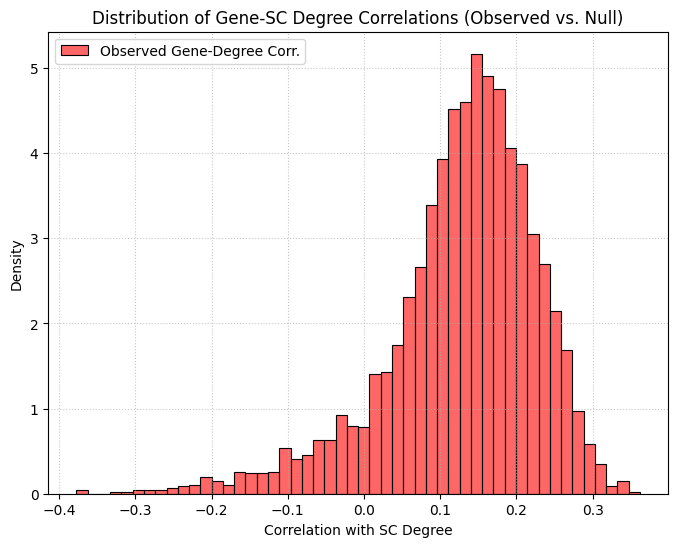

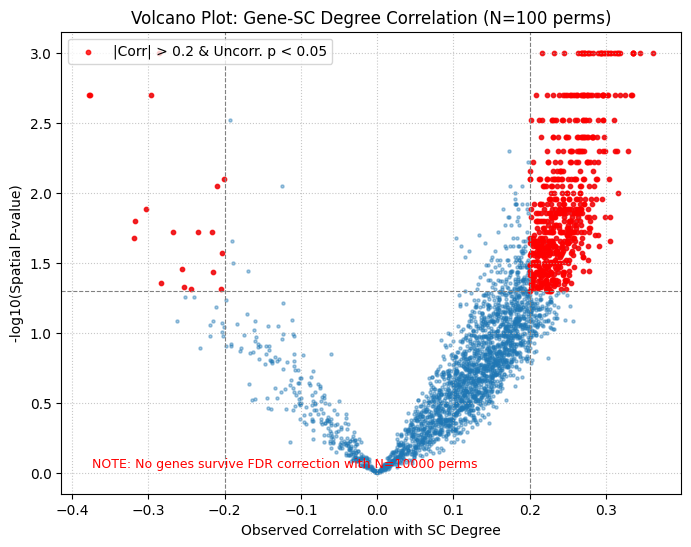

--- Finished H2 Additional Visualizations ---


In [ ]:
print("--- H2 Additional Visualizations ---")

# 1. Histogram of Observed vs. Null Correlations
plt.figure(figsize=(8, 6))
sns.histplot(observed_correlations_valid, color='red', alpha=0.6, stat='density', bins=50, label='Observed Gene-Degree Corr.')

# Flatten the null correlations and plot their distribution
if 'corr_null_pt' in locals() and corr_null_pt is not None and corr_null_pt.size > 0:
     sns.histplot(corr_null_pt.flatten(), color='gray', alpha=0.4, stat='density', bins=50, label=f'Null Correlations (N={n_permutations} perms)')

plt.title('Distribution of Gene-SC Degree Correlations (Observed vs. Null)')
plt.xlabel('Correlation with SC Degree')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()


# 2. Volcano Plot
# Use uncorrected spatial p-values for now, highlighting the limitation
plt.figure(figsize=(8, 6))

# Use -log10 of the spatial p-value
# Add small epsilon to avoid log10(0) if p=0 (unlikely with N=100)
log_p_values = -np.log10(results_df['spatial_p_value'] + 1e-10)

plt.scatter(results_df['observed_corr'], log_p_values, s=5, alpha=0.4)

# Highlight potentially interesting genes (low p, high corr), but don't claim significance yet
# Example threshold (adjust as needed)
p_thresh_uncorrected = -np.log10(0.05) # Uncorrected significance
corr_thresh = 0.2 # Arbitrary correlation threshold

highlight_indices = (log_p_values > p_thresh_uncorrected) & (np.abs(results_df['observed_corr']) > corr_thresh)
plt.scatter(results_df.loc[highlight_indices, 'observed_corr'], log_p_values[highlight_indices],
            s=10, alpha=0.8, color='red', label=f'|Corr| > {corr_thresh} & Uncorr. p < 0.05')

# Add threshold lines
plt.axhline(p_thresh_uncorrected, color='grey', linestyle='--', lw=0.8)
plt.axvline(corr_thresh, color='grey', linestyle='--', lw=0.8)
plt.axvline(-corr_thresh, color='grey', linestyle='--', lw=0.8)

plt.title('Volcano Plot: Gene-SC Degree Correlation (N=100 perms)')
plt.xlabel('Observed Correlation with SC Degree')
plt.ylabel('-log10(Spatial P-value)')
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(loc='upper left')
plt.text(0.05, 0.05, f'NOTE: No genes survive FDR correction with N={n_permutations} perms',
         transform=plt.gca().transAxes, fontsize=9, color='red', ha='left', va='bottom')
plt.show()


print("--- Finished H2 Additional Visualizations ---")

In [ ]:
# === Install gprofiler-official ===
%pip install gprofiler-official -q
print("gprofiler-official installed or already present.")

gprofiler-official installed or already present.


In [ ]:
# === GO Enrichment Analysis for SC degree===
from gprofiler import GProfiler

# !!! IMPORTANT: REPLACE THESE WITH YOUR ACTUAL GENE LISTS !!!
# These should contain the gene names/symbols that passed FDR correction
# Example structure: positive_sig_genes = ['CREB3L2', 'CD38', ...]
#                    negative_sig_genes = ['BHLHE22', 'TMEM249', ...]

# Placeholder - you MUST populate these lists from your results dataframe
positive_sig_genes = [
    'CREB3L2', 'CD38', 'VAT1', 'GRB10', 'SYNRG', 'FAM69C', 'AP3B1',
    'MSN', 'RAB2B', 'PREX2' # Add all significant positive genes here
] # Placeholder - ADD ALL YOUR POSITIVE SIG GENES
negative_sig_genes = [
    'TMEM249', 'ATP4A', 'BHLHE22', 'NEUROD1', 'HIST1H1D', 'IGDCC3', 'POMT1', 'COL5A1', 'TYRP1', 'NPPA'# Add all significant negative genes here
] # Placeholder - ADD ALL YOUR NEGATIVE SIG GENES


print(f"Number of positive significant genes provided: {len(positive_sig_genes)}")
print(f"Number of negative significant genes provided: {len(negative_sig_genes)}")

# Initialize gProfiler client
gp = GProfiler(return_dataframe=True, user_agent='gprofiler-official-example') # Be polite

# --- Analysis for POSITIVELY Correlated Genes ---
print("\n--- Enrichment for POSITIVELY correlated genes ---")
if positive_sig_genes:
    try:
        go_pos_results = gp.profile(organism='hsapiens', # Human
                                    query=positive_sig_genes,
                                    sources=['GO:BP', 'GO:MF', 'GO:CC'], # Biological Process, Molecular Function, Cellular Component
                                    user_threshold=0.05, # Standard p-value threshold for gProfiler display
                                    significance_threshold_method='fdr', # Use FDR for correction
                                    no_evidences=False) # Get evidence codes

        # Display significant results (gProfiler uses 'fdr' internally for its significance calls)
        if not go_pos_results.empty:
            print(go_pos_results[['source', 'native', 'name', 'p_value', 'significant']].head(20)) # Show top 20 terms
            # You can save the full results:
            # go_pos_results.to_csv('go_enrichment_positive_degree_genes.csv')
        else:
            print("No significant GO terms found for positively correlated genes.")

    except Exception as e:
        print(f"An error occurred during gProfiler query for positive genes: {e}")
else:
    print("No positive significant genes provided for analysis.")


# --- Analysis for NEGATIVELY Correlated Genes ---
print("\n--- Enrichment for NEGATIVELY correlated genes ---")
if negative_sig_genes:
    try:
        go_neg_results = gp.profile(organism='hsapiens',
                                    query=negative_sig_genes,
                                    sources=['GO:BP', 'GO:MF', 'GO:CC'],
                                    user_threshold=0.05,
                                    significance_threshold_method='fdr',
                                    no_evidences=False)

        # Display significant results
        if not go_neg_results.empty:
            print(go_neg_results[['source', 'native', 'name', 'p_value', 'significant']].head(20))
            # go_neg_results.to_csv('go_enrichment_negative_degree_genes.csv')
        else:
            print("No significant GO terms found for negatively correlated genes.")

    except Exception as e:
        print(f"An error occurred during gProfiler query for negative genes: {e}")
else:
    print("No negative significant genes provided for analysis.")

Number of positive significant genes provided: 10
Number of negative significant genes provided: 10

--- Enrichment for POSITIVELY correlated genes ---
   source      native                                      name   p_value  \
0   GO:CC  GO:0030131                  clathrin adaptor complex  0.006271   
1   GO:CC  GO:0030118                             clathrin coat  0.007555   
2   GO:CC  GO:0030119     AP-type membrane coat adaptor complex  0.007555   
3   GO:CC  GO:0016020                                  membrane  0.014812   
4   GO:CC  GO:0048475                           coated membrane  0.014812   
5   GO:CC  GO:0030117                             membrane coat  0.014812   
6   GO:CC  GO:0030665          clathrin-coated vesicle membrane  0.022236   
7   GO:CC  GO:0031982                                   vesicle  0.027496   
8   GO:CC  GO:0030662                   coated vesicle membrane  0.037715   
9   GO:CC  GO:0001931                                    uropod  0.038885   
1

Found 5 positive genes to plot in filtered data.
Found 4 negative genes to plot in filtered data.


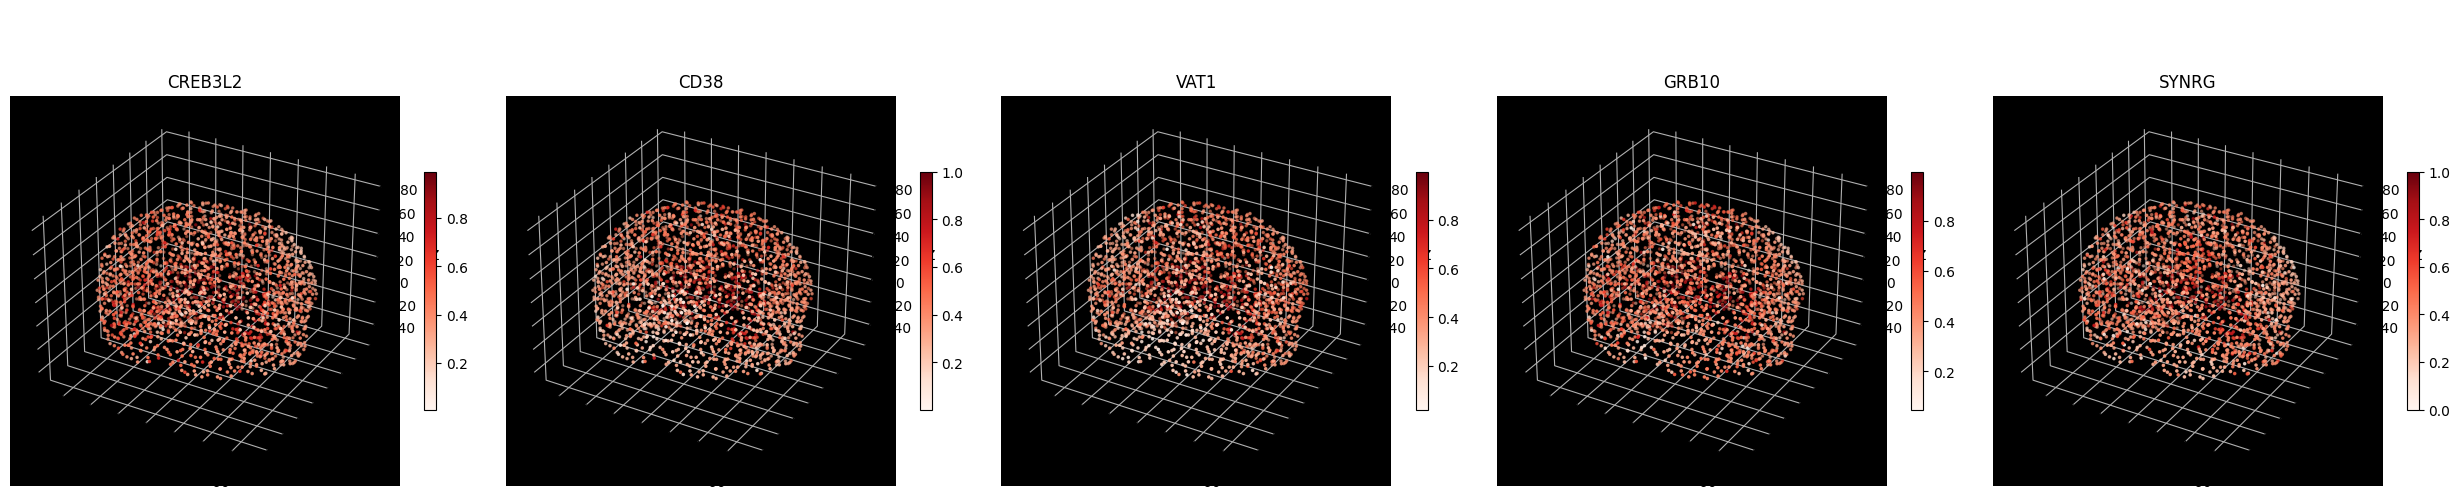

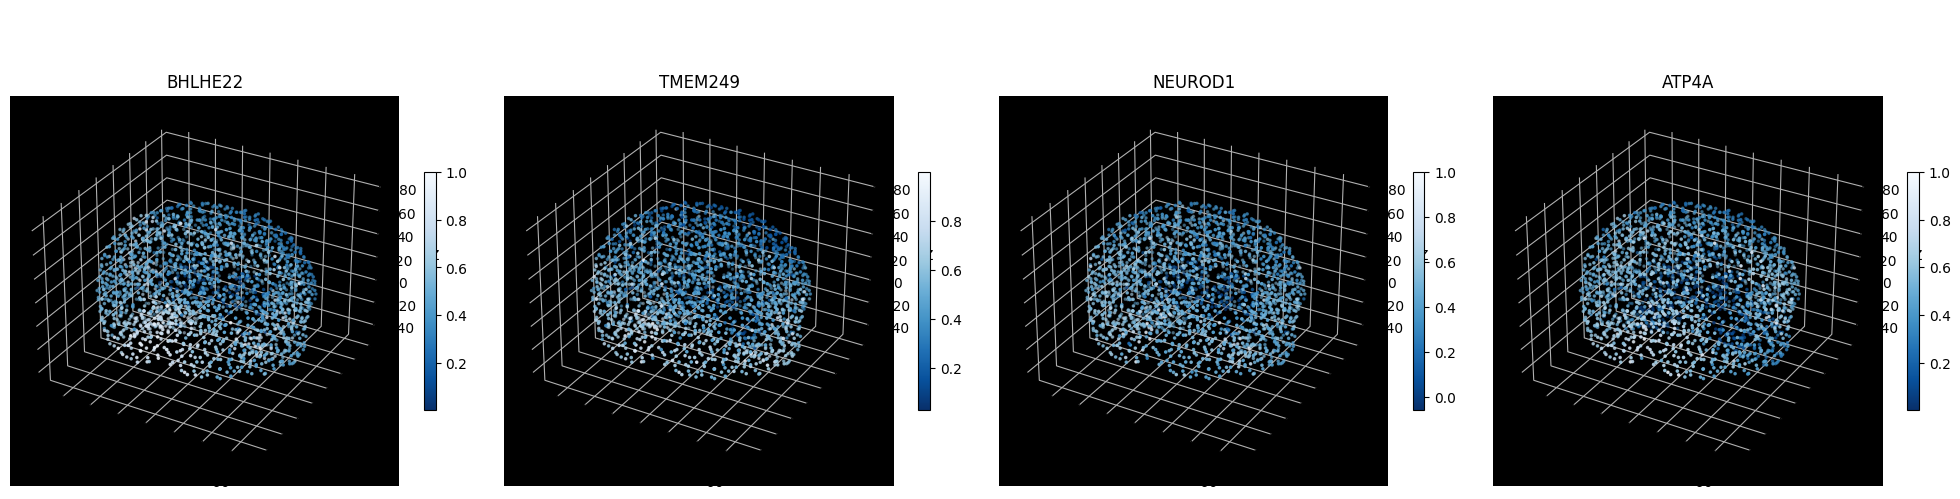

In [ ]:
# === Brain Maps of Top Correlated Genes - not very easy to see but an attempt===

# Genes identified from your text output (use more if desired)
top_pos_genes_to_plot = ['CREB3L2', 'CD38', 'VAT1', 'GRB10', 'SYNRG']
top_neg_genes_to_plot = ['BHLHE22', 'TMEM249', 'NEUROD1', 'ATP4A']

# Create a copy of the gene names for filtering
gene_names_filt = gene_names.copy() # This line is added to fix the error

# Assuming G_mat_filt is the filtered G_mat_int, rename it for clarity
G_mat_filt = G_mat_int

# Find the indices of these genes in the filtered list
plot_indices_pos = [gene_names_filt.index(g) for g in top_pos_genes_to_plot if g in gene_names_filt]
plot_indices_neg = [gene_names_filt.index(g) for g in top_neg_genes_to_plot if g in gene_names_filt]

print(f"Found {len(plot_indices_pos)} positive genes to plot in filtered data.")
print(f"Found {len(plot_indices_neg)} negative genes to plot in filtered data.")

# --- Plotting ---
n_plots_pos = len(plot_indices_pos)
n_plots_neg = len(plot_indices_neg)
dotSize = 10

# Plot Positive Genes
if n_plots_pos > 0:
    fig_pos = plt.figure(figsize=(5 * n_plots_pos, 5))
    fig_pos.suptitle('Expression Patterns of Top POSITIVELY Degree-Correlated Genes', color='white', y=1.02)
    for i, gene_idx in enumerate(plot_indices_pos):
        gene_name = gene_names_filt[gene_idx]
        expression_vector = G_mat_filt[gene_idx, :]

        ax = fig_pos.add_subplot(1, n_plots_pos, i + 1, projection='3d')
        sc = ax.scatter(roiCoor_clean[:, 0], roiCoor_clean[:, 1], roiCoor_clean[:, 2],
                        s=dotSize, c=expression_vector, cmap='Reds', marker='.') # Use 'Reds' for positive
        ax.set_title(f'{gene_name}')
        ax.set_facecolor('k')
        ax.xaxis.set_pane_color((0,0,0,1)); ax.yaxis.set_pane_color((0,0,0,1)); ax.zaxis.set_pane_color((0,0,0,1))
        fig_pos.colorbar(sc, ax=ax, shrink=0.6)
        ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

# Plot Negative Genes
if n_plots_neg > 0:
    fig_neg = plt.figure(figsize=(5 * n_plots_neg, 5))
    fig_neg.suptitle('Expression Patterns of Top NEGATIVELY Degree-Correlated Genes', color='white', y=1.02)
    for i, gene_idx in enumerate(plot_indices_neg):
        gene_name = gene_names_filt[gene_idx]
        expression_vector = G_mat_filt[gene_idx, :]

        ax = fig_neg.add_subplot(1, n_plots_neg, i + 1, projection='3d')
        sc = ax.scatter(roiCoor_clean[:, 0], roiCoor_clean[:, 1], roiCoor_clean[:, 2],
                        s=dotSize, c=expression_vector, cmap='Blues_r', marker='.') # Use reverse 'Blues' for negative
        ax.set_title(f'{gene_name}')
        ax.set_facecolor('k')
        ax.xaxis.set_pane_color((0,0,0,1)); ax.yaxis.set_pane_color((0,0,0,1)); ax.zaxis.set_pane_color((0,0,0,1))
        fig_neg.colorbar(sc, ax=ax, shrink=0.6)
        ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
# === H2 with FC instead of SC ===
import time
from statsmodels.stats.multitest import fdrcorrection # For FDR

# Calculate Functional Degree (using the cleaned, median FC matrix)
functional_degree = np.sum(np.abs(fcm_clean), axis=1)# For directed: degree = np.sum(scm_binary, axis=0) + np.sum(scm_binary, axis=1)

# 2. Correlate Genes with Degree (Observed)
print("Calculating observed gene-degree correlations...")
n_genes = G_mat_int.shape[0]
observed_correlations = np.zeros(n_genes)
for i in range(n_genes):
    # G_mat_int[i, :] is the expression vector for gene i across ROIs
    # Check for NaNs or zero variance in gene expression
    gene_expr = G_mat_int[i, :]
    if np.any(np.isnan(gene_expr)) or np.std(gene_expr) < 1e-9:
        observed_correlations[i] = np.nan # Assign NaN if problematic
    else:
        observed_correlations[i] = pearsonr(gene_expr, functional_degree)[0]

# Remove NaN correlations before permutation testing
valid_gene_indices = np.where(~np.isnan(observed_correlations))[0]
observed_correlations_valid = observed_correlations[valid_gene_indices]
print(f"Calculated {len(observed_correlations_valid)} valid observed correlations.")

# 3. Spatial Null Model (using permtest_pearsonr)
print(f"Performing spatial permutation test for {len(observed_correlations_valid)} genes...")
# We correlate each valid gene's expression (rows of G_mat_int[valid_gene_indices, :].T)
# with the fixed degree vector.
# `permtest_pearsonr` takes (data, x, y), where data contains coordinates.
# It permutes columns of x relative to y based on spatial proximity defined by data.
# Here: x = gene expression (ROIs x Genes), y = degree (ROIs x 1)

# Prepare data for permtest_pearsonr
X_genes = G_mat_int[valid_gene_indices, :].T # Shape: (n_rois_clean, n_valid_genes)
Y_degree = functional_degree.reshape(-1, 1) # Shape: (n_rois_clean, 1)

# Perform the test (this might take some time)
# Ensure coordinates are passed correctly

observed_corr, pval_spatial = nnstats.permtest_pearsonr(X_genes, Y_degree, axis=0, n_perm=1000, resamples=spins, seed=1234)

print("Finished spatial permutation test.")
# Note: corr_obs_pt should match observed_correlations_valid (or Spearman equivalent)
# pval_spatial contains the spatially corrected p-values for each gene


# 4. FDR Correction
print("Performing FDR correction...")
if pval_spatial.size > 0:
    reject, pval_fdr, _, _ = multipletests(pval_spatial, method='fdr_bh')
    print(f"Found {np.sum(reject)} genes significantly correlated with degree after FDR.")
else:
    print("No valid p-values to correct.")
    reject = np.array([])
    pval_fdr = np.array([])

# Store results in a DataFrame for easier handling
results_df = pd.DataFrame({
    'gene_index': valid_gene_indices,
    'gene_name': [gene_names[i] for i in valid_gene_indices],
    'observed_corr': observed_correlations_valid,
    'spatial_p_value': pval_spatial,
    'fdr_p_value': pval_fdr,
    'significant': reject
})

# Sort by significance and correlation strength
results_df_sorted = results_df.sort_values(by=['significant', 'fdr_p_value', 'observed_corr'], ascending=[False, True, False])

print("\nTop 10 genes most positively correlated with degree (after spatial correction):")
print(results_df_sorted[results_df_sorted['observed_corr'] > 0].head(10))

print("\nTop 10 genes most negatively correlated with degree (after spatial correction):")
print(results_df_sorted[results_df_sorted['observed_corr'] < 0].head(10))


print("--- Finished Hypothesis 2 (Part 2) ---")

Calculating observed gene-degree correlations...
Calculated 3127 valid observed correlations.
Performing spatial permutation test for 3127 genes...
Finished spatial permutation test.
Performing FDR correction...
Found 0 genes significantly correlated with degree after FDR.

Top 10 genes most positively correlated with degree (after spatial correction):
      gene_index  gene_name  observed_corr  spatial_p_value  fdr_p_value  \
18            18       ACAN       0.445885         0.000999     0.283989   
2934        2934      VAMP1       0.400419         0.004995     0.302311   
2228        2228        RET       0.366900         0.005994     0.302311   
1432        1432  LINC01137       0.365000         0.001998     0.302311   
1365        1365       LAG3       0.410275         0.010989     0.327263   
2159        2159       PTX3       0.308389         0.009990     0.327263   
780          780       EPN3       0.404258         0.011988     0.328829   
572          572       CUX1       0.3

--- H2 Additional Visualizations ---


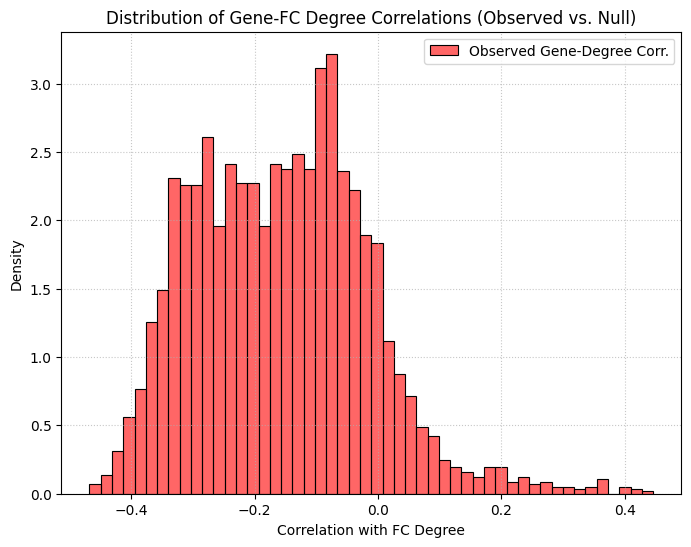

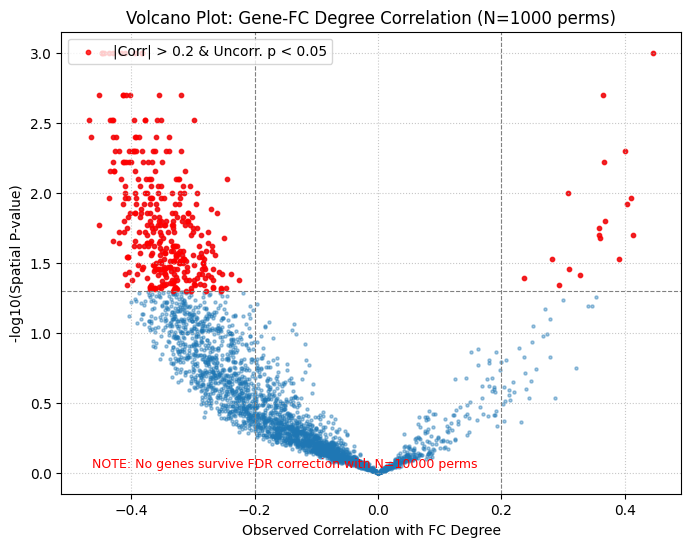

--- Finished H2 Additional Visualizations ---


In [ ]:
print("--- H2 Additional Visualizations ---")

# 1. Histogram of Observed vs. Null Correlations
plt.figure(figsize=(8, 6))
sns.histplot(observed_correlations_valid, color='red', alpha=0.6, stat='density', bins=50, label='Observed Gene-Degree Corr.')

# Flatten the null correlations and plot their distribution
if 'corr_null_pt' in locals() and corr_null_pt is not None and corr_null_pt.size > 0:
     sns.histplot(corr_null_pt.flatten(), color='gray', alpha=0.4, stat='density', bins=50, label=f'Null Correlations (N={n_permutations} perms)')

plt.title('Distribution of Gene-FC Degree Correlations (Observed vs. Null)')
plt.xlabel('Correlation with FC Degree')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()


# 2. Volcano Plot
# Use uncorrected spatial p-values for now, highlighting the limitation
plt.figure(figsize=(8, 6))

# Use -log10 of the spatial p-value
# Add small epsilon to avoid log10(0) if p=0 (unlikely with N=100)
log_p_values = -np.log10(results_df['spatial_p_value'] + 1e-10)

plt.scatter(results_df['observed_corr'], log_p_values, s=5, alpha=0.4)

# Highlight potentially interesting genes (low p, high corr), but don't claim significance yet
# Example threshold (adjust as needed)
p_thresh_uncorrected = -np.log10(0.05) # Uncorrected significance
corr_thresh = 0.2 # Arbitrary correlation threshold

highlight_indices = (log_p_values > p_thresh_uncorrected) & (np.abs(results_df['observed_corr']) > corr_thresh)
plt.scatter(results_df.loc[highlight_indices, 'observed_corr'], log_p_values[highlight_indices],
            s=10, alpha=0.8, color='red', label=f'|Corr| > {corr_thresh} & Uncorr. p < 0.05')

# Add threshold lines
plt.axhline(p_thresh_uncorrected, color='grey', linestyle='--', lw=0.8)
plt.axvline(corr_thresh, color='grey', linestyle='--', lw=0.8)
plt.axvline(-corr_thresh, color='grey', linestyle='--', lw=0.8)

plt.title('Volcano Plot: Gene-FC Degree Correlation (N=1000 perms)')
plt.xlabel('Observed Correlation with FC Degree')
plt.ylabel('-log10(Spatial P-value)')
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(loc='upper left')
plt.text(0.05, 0.05, f'NOTE: No genes survive FDR correction with N={n_permutations} perms',
         transform=plt.gca().transAxes, fontsize=9, color='red', ha='left', va='bottom')
plt.show()


print("--- Finished H2 Additional Visualizations ---")

In [ ]:
# === GO Enrichment Analysis for degree vs FC ===
from gprofiler import GProfiler

# !!! IMPORTANT: REPLACE THESE WITH YOUR ACTUAL GENE LISTS !!!
# These should contain the gene names/symbols that passed FDR correction
# Example structure: positive_sig_genes = ['CREB3L2', 'CD38', ...]
#                    negative_sig_genes = ['BHLHE22', 'TMEM249', ...]

# Placeholder - you MUST populate these lists from your results dataframe
positive_sig_genes = [
    'ACAN', 'VAMP1', 'RET', 'LINC01137', 'LAG3', 'PTX3', 'EPN3',
    'CUX1', 'KNG1', 'LRRC38' # Add all significant positive genes here
] # Placeholder - ADD ALL YOUR POSITIVE SIG GENES
negative_sig_genes = [
    'CEP83', 'TNNT1', 'FZD2', 'TRIM24', 'CPNE6', 'RIIAD1' , 'ASCL2', 'IL33', 'CEBPA', 'KCNA5'# Add all significant negative genes here
] # Placeholder - ADD ALL YOUR NEGATIVE SIG GENES


print(f"Number of positive significant genes provided: {len(positive_sig_genes)}")
print(f"Number of negative significant genes provided: {len(negative_sig_genes)}")

# Initialize gProfiler client
gp = GProfiler(return_dataframe=True, user_agent='gprofiler-official-example') # Be polite

# --- Analysis for POSITIVELY Correlated Genes ---
print("\n--- Enrichment for POSITIVELY correlated genes ---")
if positive_sig_genes:
    try:
        go_pos_results = gp.profile(organism='hsapiens', # Human
                                    query=positive_sig_genes,
                                    sources=['GO:BP', 'GO:MF', 'GO:CC'], # Biological Process, Molecular Function, Cellular Component
                                    user_threshold=0.05, # Standard p-value threshold for gProfiler display
                                    significance_threshold_method='fdr', # Use FDR for correction
                                    no_evidences=False) # Get evidence codes

        # Display significant results (gProfiler uses 'fdr' internally for its significance calls)
        if not go_pos_results.empty:
            print(go_pos_results[['source', 'native', 'name', 'p_value', 'significant']].head(20)) # Show top 20 terms
            # You can save the full results:
            # go_pos_results.to_csv('go_enrichment_positive_degree_genes.csv')
        else:
            print("No significant GO terms found for positively correlated genes.")

    except Exception as e:
        print(f"An error occurred during gProfiler query for positive genes: {e}")
else:
    print("No positive significant genes provided for analysis.")


# --- Analysis for NEGATIVELY Correlated Genes ---
print("\n--- Enrichment for NEGATIVELY correlated genes ---")
if negative_sig_genes:
    try:
        go_neg_results = gp.profile(organism='hsapiens',
                                    query=negative_sig_genes,
                                    sources=['GO:BP', 'GO:MF', 'GO:CC'],
                                    user_threshold=0.05,
                                    significance_threshold_method='fdr',
                                    no_evidences=False)

        # Display significant results
        if not go_neg_results.empty:
            print(go_neg_results[['source', 'native', 'name', 'p_value', 'significant']].head(20))
            # go_neg_results.to_csv('go_enrichment_negative_degree_genes.csv')
        else:
            print("No significant GO terms found for negatively correlated genes.")

    except Exception as e:
        print(f"An error occurred during gProfiler query for negative genes: {e}")
else:
    print("No negative significant genes provided for analysis.")

Number of positive significant genes provided: 10
Number of negative significant genes provided: 10

--- Enrichment for POSITIVELY correlated genes ---
   source      native                                               name  \
0   GO:CC  GO:0012505                                endomembrane system   
1   GO:CC  GO:0098796                           membrane protein complex   
2   GO:CC  GO:0071944                                     cell periphery   
3   GO:CC  GO:0070820                                   tertiary granule   
4   GO:CC  GO:0042581                                   specific granule   
5   GO:CC  GO:0097708                              intracellular vesicle   
6   GO:CC  GO:0031012                               extracellular matrix   
7   GO:CC  GO:0030312                   external encapsulating structure   
8   GO:CC  GO:0031410                                cytoplasmic vesicle   
9   GO:BP  GO:0072298   regulation of metanephric glomerulus development   
10  GO:BP  G